### What is Dimensionality Reduction?

**Dimensionality** reduction is the process of reducing the number of variables (features) in a dataset while preserving as much relevant information as possible. This is useful for:

- Simplifying models
- Visualizing high-dimensional data
- Reducing noise and overfitting
- Improving computational efficiency

---

### What is PCA?

**Principal Component Analysis (PCA)** is an unsupervised method that transforms the original features into a new set of orthogonal axes (principal components) that capture the maximum variance in the data.

- **Goal:** Maximize variance explained.
- **Does not use class labels.**
- **Best for:** Exploratory analysis, noise reduction, visualization.

---

### What is LDA?

**Linear Discriminant Analysis (LDA)** is a supervised method that finds new axes (linear discriminants) which maximize the separation between multiple classes.

- **Goal:** Maximize class separability.
- **Uses class labels.**
- **Best for:** Classification tasks, understanding group differences.

---

### Summary Table

| Method | Supervised? | Optimizes         | Typical Use                        |
|--------|-------------|-------------------|------------------------------------|
| PCA    | No          | Variance          | Visualization, noise reduction     |
| LDA    | Yes         | Class separation  | Classification, feature extraction |

In [1]:
# Load the combined EEG data and apply PCA

# Load data
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


eeg_df = pd.read_csv('Data/combined_eeg_data.csv')
print(f"Loaded EEG data: {eeg_df.shape[0]} rows, {eeg_df.shape[1]} columns")

# Prepare feature columns (exclude non-numeric/categorical columns)
exclude_cols = ['participant', 'trial', 'condition', 'electrode', 'frequency', 'coeff']
feature_cols = [col for col in eeg_df.columns if col not in exclude_cols]

# If no numeric features, extract magnitude/phase from 'coeff'
if not feature_cols and 'coeff' in eeg_df.columns:
    eeg_df['coeff'] = eeg_df['coeff'].apply(lambda x: complex(x.replace('j', 'j')) if isinstance(x, str) else x)
    eeg_df['magnitude'] = eeg_df['coeff'].apply(lambda x: abs(x) if isinstance(x, complex) else np.nan)
    eeg_df['phase'] = eeg_df['coeff'].apply(lambda x: np.angle(x) if isinstance(x, complex) else np.nan)
    feature_cols = ['magnitude', 'phase']

# Drop rows with missing feature values
eeg_df = eeg_df.dropna(subset=feature_cols)

# Standardize features
scaler = StandardScaler()
X = scaler.fit_transform(eeg_df[feature_cols])

# Apply PCA
pca = PCA()
X_pca = pca.fit_transform(X)

print(f"PCA applied: {X_pca.shape[1]} components")
print(f"Explained variance ratio (first 5): {pca.explained_variance_ratio_[:5]}")

Loaded EEG data: 3118080 rows, 6 columns
PCA applied: 2 components
Explained variance ratio (first 5): [0.50037893 0.49962107]


### How to Choose the Number of PCA Components

When using Principal Component Analysis (PCA), selecting the optimal number of components is crucial for balancing dimensionality reduction and information retention. Here are two common strategies:

**1. Explained Variance Threshold:**  
Choose the smallest number of components that together explain a desired proportion of the total variance in the data (commonly 90% or 95%). This ensures most of the important information is preserved.

**2. Scree Plot (Elbow Method):**  
Plot the explained variance ratio for each principal component. Look for the "elbow" point in the plot—this is where adding more components results in only marginal gains in explained variance. Select the number of components at or just after this elbow.



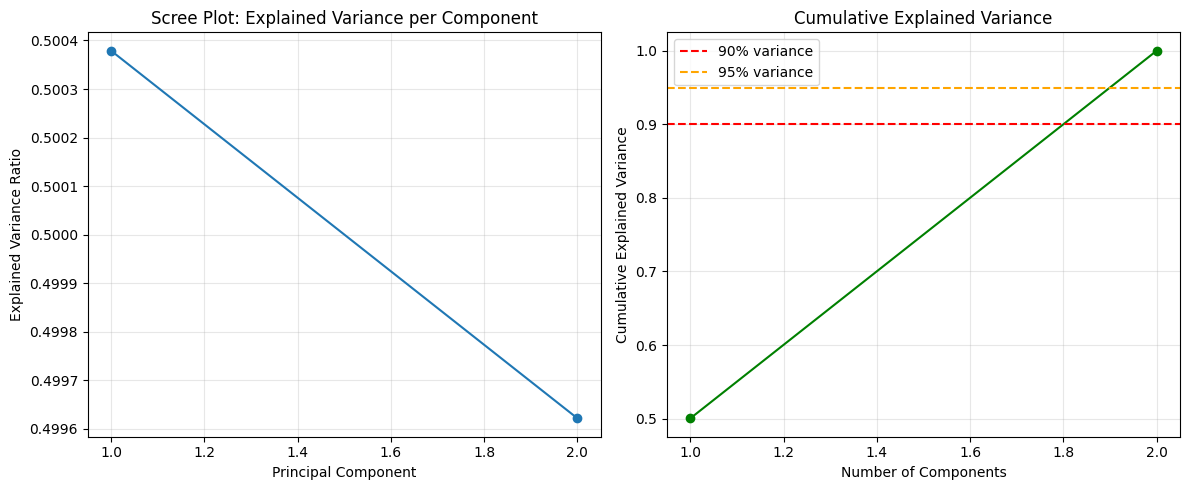

Number of components to reach 90% variance: 2
Number of components to reach 95% variance: 2


In [3]:
import matplotlib.pyplot as plt
explained_var = pca.explained_variance_ratio_
cumulative_var = np.cumsum(explained_var)

plt.figure(figsize=(12, 5))

# Scree plot (explained variance per component)
plt.subplot(1, 2, 1)
plt.plot(range(1, len(explained_var) + 1), explained_var, marker='o')
plt.title('Scree Plot: Explained Variance per Component')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.grid(True, alpha=0.3)

# Cumulative explained variance
plt.subplot(1, 2, 2)
plt.plot(range(1, len(cumulative_var) + 1), cumulative_var, marker='o', color='green')
plt.axhline(0.90, color='red', linestyle='--', label='90% variance')
plt.axhline(0.95, color='orange', linestyle='--', label='95% variance')
plt.title('Cumulative Explained Variance')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print number of components needed for 90% and 95% variance
for threshold in [0.90, 0.95]:
    n_comp = np.argmax(cumulative_var >= threshold) + 1
    print(f"Number of components to reach {int(threshold*100)}% variance: {n_comp}")

In [4]:
pca = PCA(n_components=0.90)
X_pca = pca.fit_transform(X)

# Name PCA columns based on number of components
pca_cols = [f'PCA_comp_{i+1}' for i in range(X_pca.shape[1])]
# Combine with metadata
pca_df = eeg_df[['participant', 'trial', 'condition']].reset_index(drop=True).copy()
for i, col in enumerate(pca_cols):
    pca_df[col] = X_pca[:, i]

# Save to CSV
pca_df.to_csv('Data/pca_reduced_data_full.csv', index=False)
print(f"PCA-reduced data saved to Data/pca_reduced_data_full.csv with shape {pca_df.shape}")


PCA-reduced data saved to Data/pca_reduced_data_full.csv with shape (3118080, 5)


### out of curiosity i an goining compare PCA and LDA in a practical example:


Loaded EEG data: (3118080, 6)
PCA vs LDA DIMENSIONALITY REDUCTION COMPARISON

1. DIMENSIONALITY REDUCTION ANALYSIS
--------------------------------------------------
Original dimensions: 2
PCA max dimensions: 2
LDA max dimensions: 2

PCA components needed:
  90% variance: 2 components
  95% variance: 2 components
  99% variance: 2 components

LDA components:
  Total available: 2 components
  Total variance explained: 1.0000

Dimensionality reduction factors:
  PCA (90% var): 1.0x reduction
  PCA (95% var): 1.0x reduction
  PCA (99% var): 1.0x reduction
  LDA (all): 1.0x reduction

2. INFORMATION PRESERVATION vs COMPRESSION TRADE-OFF
--------------------------------------------------
Components   PCA Accuracy    PCA Variance    LDA Accuracy    LDA Variance   
---------------------------------------------------------------------------
1            0.2506          0.5004          0.2516          0.9949         
2            0.2515          1.0000          0.2515          1.0000         
3

NameError: name 'recommendation' is not defined

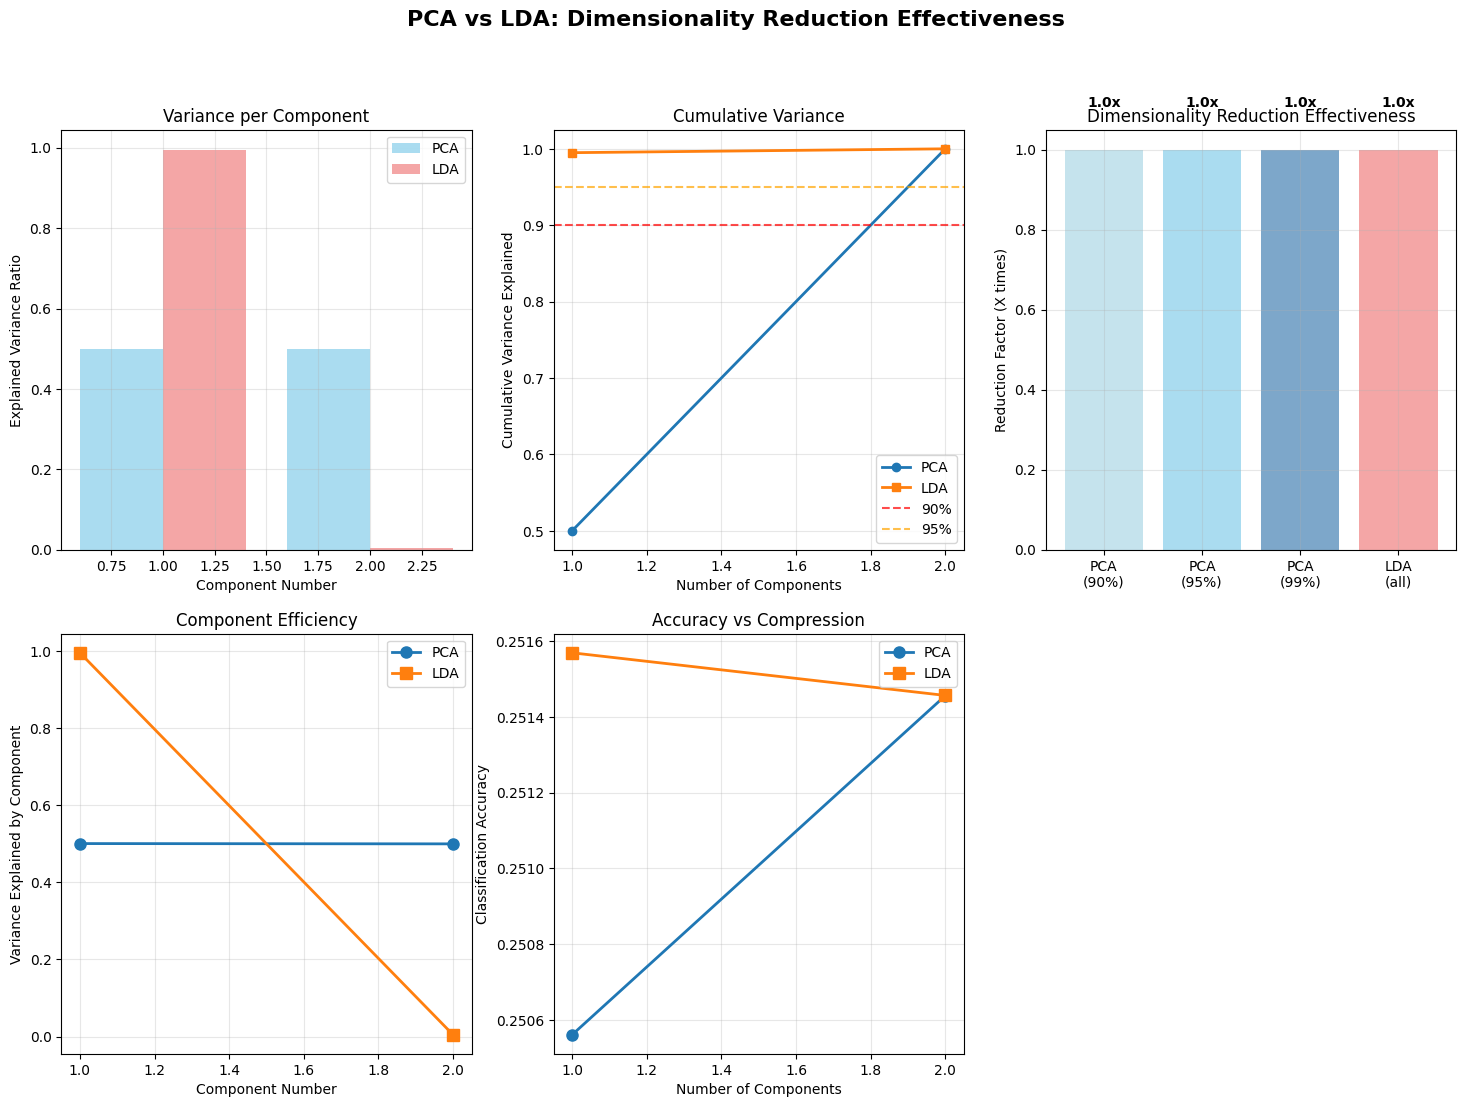

In [8]:
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
import warnings
warnings.filterwarnings('ignore')

def compare_pca_vs_lda_for_dimensionality_reduction(X, y):
    """
    Comprehensive comparison between PCA and LDA for effective dimensionality reduction
    
    Parameters:
    X: Feature matrix
    y: Target labels (required for LDA)
    """
    
    print("="*80)
    print("PCA vs LDA DIMENSIONALITY REDUCTION COMPARISON")
    print("="*80)
    
    # Standardize data
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Apply PCA
    n_pca_components = min(8, X_scaled.shape[1])
    pca = PCA(n_components=n_pca_components)
    X_pca = pca.fit_transform(X_scaled)
    
    # Apply LDA
    n_lda_components = min(3, X_scaled.shape[1], len(np.unique(y)) - 1)
    lda = LDA(n_components=n_lda_components)
    X_lda = lda.fit_transform(X_scaled, y)
    
    results = {}
    
    # 1. DIMENSIONALITY REDUCTION EFFECTIVENESS
    print("\n1. DIMENSIONALITY REDUCTION ANALYSIS")
    print("-" * 50)
    
    results['original_dims'] = X_scaled.shape[1]
    results['pca_dims'] = X_pca.shape[1]
    results['lda_dims'] = X_lda.shape[1]
    
    print(f"Original dimensions: {results['original_dims']}")
    print(f"PCA max dimensions: {results['pca_dims']}")
    print(f"LDA max dimensions: {results['lda_dims']}")
    
    # PCA variance thresholds
    pca_90 = np.argmax(np.cumsum(pca.explained_variance_ratio_) >= 0.9) + 1
    pca_95 = np.argmax(np.cumsum(pca.explained_variance_ratio_) >= 0.95) + 1
    pca_99 = np.argmax(np.cumsum(pca.explained_variance_ratio_) >= 0.99) + 1
    
    results['pca_90_dims'] = pca_90
    results['pca_95_dims'] = pca_95
    results['pca_99_dims'] = pca_99
    results['lda_total_variance'] = lda.explained_variance_ratio_.sum()
    
    print(f"\nPCA components needed:")
    print(f"  90% variance: {pca_90} components")
    print(f"  95% variance: {pca_95} components")
    print(f"  99% variance: {pca_99} components")
    print(f"\nLDA components:")
    print(f"  Total available: {results['lda_dims']} components")
    print(f"  Total variance explained: {results['lda_total_variance']:.4f}")
    
    # Calculate reduction factors
    print(f"\nDimensionality reduction factors:")
    print(f"  PCA (90% var): {results['original_dims']/pca_90:.1f}x reduction")
    print(f"  PCA (95% var): {results['original_dims']/pca_95:.1f}x reduction") 
    print(f"  PCA (99% var): {results['original_dims']/pca_99:.1f}x reduction")
    print(f"  LDA (all): {results['original_dims']/results['lda_dims']:.1f}x reduction")
    
    # 2. INFORMATION PRESERVATION vs COMPRESSION
    print("\n2. INFORMATION PRESERVATION vs COMPRESSION TRADE-OFF")
    print("-" * 50)
    
    # Test different component numbers for both methods
    component_tests = [1, 2, 3, 5, min(10, results['original_dims'])]
    classifier = LogisticRegression(random_state=42, max_iter=1000)
    
    pca_results = {}
    lda_results = {}
    
    print(f"{'Components':<12} {'PCA Accuracy':<15} {'PCA Variance':<15} {'LDA Accuracy':<15} {'LDA Variance':<15}")
    print("-" * 75)
    
    for n_comp in component_tests:
        # PCA performance
        if n_comp <= X_pca.shape[1]:
            X_pca_subset = X_pca[:, :n_comp]
            pca_cv_scores = cross_val_score(classifier, X_pca_subset, y, cv=5)
            pca_acc = pca_cv_scores.mean()
            pca_var = np.sum(pca.explained_variance_ratio_[:n_comp])
            pca_results[n_comp] = {'accuracy': pca_acc, 'variance': pca_var}
        else:
            pca_acc, pca_var = "N/A", "N/A"
            
        # LDA performance  
        if n_comp <= X_lda.shape[1]:
            X_lda_subset = X_lda[:, :n_comp]
            lda_cv_scores = cross_val_score(classifier, X_lda_subset, y, cv=5)
            lda_acc = lda_cv_scores.mean()
            lda_var = np.sum(lda.explained_variance_ratio_[:n_comp])
            lda_results[n_comp] = {'accuracy': lda_acc, 'variance': lda_var}
        else:
            lda_acc, lda_var = "N/A", "N/A"
            
        # Format output
        pca_acc_str = f"{pca_acc:.4f}" if pca_acc != "N/A" else "N/A"
        pca_var_str = f"{pca_var:.4f}" if pca_var != "N/A" else "N/A" 
        lda_acc_str = f"{lda_acc:.4f}" if lda_acc != "N/A" else "N/A"
        lda_var_str = f"{lda_var:.4f}" if lda_var != "N/A" else "N/A"
        
        print(f"{n_comp:<12} {pca_acc_str:<15} {pca_var_str:<15} {lda_acc_str:<15} {lda_var_str:<15}")
    
    results['pca_performance'] = pca_results
    results['lda_performance'] = lda_results
    
    # 3. EFFICIENCY METRICS
    print("\n3. DIMENSIONALITY REDUCTION EFFICIENCY")
    print("-" * 50)
    
    # Calculate efficiency scores (variance preserved per component)
    pca_efficiency = []
    lda_efficiency = []
    
    for i in range(min(5, len(pca.explained_variance_ratio_))):
        pca_efficiency.append(pca.explained_variance_ratio_[i])
        
    for i in range(min(5, len(lda.explained_variance_ratio_))):
        lda_efficiency.append(lda.explained_variance_ratio_[i])
    
    print("Variance per component (efficiency):")
    print(f"{'Component':<12} {'PCA':<15} {'LDA':<15}")
    print("-" * 42)
    
    max_components = max(len(pca_efficiency), len(lda_efficiency))
    for i in range(max_components):
        pca_val = f"{pca_efficiency[i]:.4f}" if i < len(pca_efficiency) else "N/A"
        lda_val = f"{lda_efficiency[i]:.4f}" if i < len(lda_efficiency) else "N/A"
        print(f"{i+1:<12} {pca_val:<15} {lda_val:<15}")
    
    # 4. RECOMMENDATION BASED ON DIMENSIONALITY REDUCTION GOALS
    print("\n4. DIMENSIONALITY REDUCTION RECOMMENDATION")
    print("=" * 50)
    
    # Score each method based on reduction effectiveness
    scores = {
        'PCA': {
            'max_reduction': results['original_dims'] / results['lda_dims'],  # Compare to LDA's max
            'variance_preservation': np.sum(pca.explained_variance_ratio_[:min(3, len(pca.explained_variance_ratio_))]),
            'flexibility': 1.0,  # Can choose any number of components
            'efficiency_90': results['original_dims'] / pca_90,
            'efficiency_95': results['original_dims'] / pca_95
        },
        'LDA': {
            'max_reduction': results['original_dims'] / results['lda_dims'],
            'variance_preservation': results['lda_total_variance'],
            'flexibility': 0.7,  # Limited by n_classes - 1
            'efficiency_max': results['original_dims'] / results['lda_dims'],
            'supervised_advantage': 1.0  # Uses class information
        }
    }
    

    print(f"  • Maximum possible reduction: {scores['PCA']['max_reduction']:.1f}x")
    print(f"  • 90% variance reduction: {scores['PCA']['efficiency_90']:.1f}x")
    print(f"  • 95% variance reduction: {scores['PCA']['efficiency_95']:.1f}x")

    
    print(f"\nLDA Reduction Effectiveness:")
    print(f"  • Maximum reduction: {scores['LDA']['max_reduction']:.1f}x")
    print(f"  • All components variance: {scores['LDA']['variance_preservation']:.4f}")

    



    # 6. VISUALIZATION
    create_dimensionality_reduction_plots(X_pca, X_lda, y, pca, lda, results)
    
    results['recommendation'] = recommendation
    results['reason'] = reason
    
    return results

def create_dimensionality_reduction_plots(X_pca, X_lda, y, pca, lda, results):
    """Create visualizations focused on dimensionality reduction effectiveness"""
    
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle('PCA vs LDA: Dimensionality Reduction Effectiveness', fontsize=16, fontweight='bold')
    
    # Plot 1: Explained Variance Comparison
    ax1 = axes[0, 0]
    n_show = min(10, len(pca.explained_variance_ratio_))
    x_pos = np.arange(1, n_show + 1)
    
    ax1.bar(x_pos - 0.2, pca.explained_variance_ratio_[:n_show], 0.4, 
            label='PCA', alpha=0.7, color='skyblue')
    if len(lda.explained_variance_ratio_) > 0:
        n_lda_show = min(n_show, len(lda.explained_variance_ratio_))
        ax1.bar(x_pos[:n_lda_show] + 0.2, lda.explained_variance_ratio_[:n_lda_show], 0.4, 
                label='LDA', alpha=0.7, color='lightcoral')
    
    ax1.set_xlabel('Component Number')
    ax1.set_ylabel('Explained Variance Ratio')
    ax1.set_title('Variance per Component')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Plot 2: Cumulative Variance
    ax2 = axes[0, 1]
    pca_cumvar = np.cumsum(pca.explained_variance_ratio_)
    lda_cumvar = np.cumsum(lda.explained_variance_ratio_)
    
    ax2.plot(range(1, len(pca_cumvar) + 1), pca_cumvar, 'o-', label='PCA', linewidth=2)
    ax2.plot(range(1, len(lda_cumvar) + 1), lda_cumvar, 's-', label='LDA', linewidth=2)
    ax2.axhline(0.9, color='red', linestyle='--', alpha=0.7, label='90%')
    ax2.axhline(0.95, color='orange', linestyle='--', alpha=0.7, label='95%')
    
    ax2.set_xlabel('Number of Components')
    ax2.set_ylabel('Cumulative Variance Explained')
    ax2.set_title('Cumulative Variance')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # Plot 3: Dimensionality Reduction Factors
    ax3 = axes[0, 2]
    
    methods = ['PCA\n(90%)', 'PCA\n(95%)', 'PCA\n(99%)', 'LDA\n(all)']
    reductions = [
        results['original_dims'] / results['pca_90_dims'],
        results['original_dims'] / results['pca_95_dims'], 
        results['original_dims'] / results['pca_99_dims'],
        results['original_dims'] / results['lda_dims']
    ]
    
    colors = ['lightblue', 'skyblue', 'steelblue', 'lightcoral']
    bars = ax3.bar(methods, reductions, color=colors, alpha=0.7)
    
    ax3.set_ylabel('Reduction Factor (X times)')
    ax3.set_title('Dimensionality Reduction Effectiveness')
    ax3.grid(True, alpha=0.3)
    
    # Add value labels
    for bar, reduction in zip(bars, reductions):
        ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1, 
                f'{reduction:.1f}x', ha='center', va='bottom', fontweight='bold')
    
    # Plot 4: Component Efficiency (Variance per Component)
    ax4 = axes[1, 0]
    n_components = min(5, max(len(pca.explained_variance_ratio_), len(lda.explained_variance_ratio_)))
    
    pca_eff = pca.explained_variance_ratio_[:n_components]
    lda_eff = lda.explained_variance_ratio_[:min(n_components, len(lda.explained_variance_ratio_))]
    
    x = np.arange(1, n_components + 1)
    ax4.plot(x[:len(pca_eff)], pca_eff, 'o-', label='PCA', linewidth=2, markersize=8)
    ax4.plot(x[:len(lda_eff)], lda_eff, 's-', label='LDA', linewidth=2, markersize=8)
    
    ax4.set_xlabel('Component Number')
    ax4.set_ylabel('Variance Explained by Component')
    ax4.set_title('Component Efficiency')
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    
    # Plot 5: Classification Performance vs Components
    ax5 = axes[1, 1]
    
    if results['pca_performance'] and results['lda_performance']:
        pca_comps = list(results['pca_performance'].keys())
        pca_accs = [results['pca_performance'][k]['accuracy'] for k in pca_comps]
        lda_comps = list(results['lda_performance'].keys())
        lda_accs = [results['lda_performance'][k]['accuracy'] for k in lda_comps]
        
        ax5.plot(pca_comps, pca_accs, 'o-', label='PCA', linewidth=2, markersize=8)
        ax5.plot(lda_comps, lda_accs, 's-', label='LDA', linewidth=2, markersize=8)
        
        ax5.set_xlabel('Number of Components')
        ax5.set_ylabel('Classification Accuracy')
        ax5.set_title('Accuracy vs Compression')
        ax5.legend()
        ax5.grid(True, alpha=0.3)
    
    # Plot 6: Summary Statistics
    ax6 = axes[1, 2]
    ax6.axis('off')
    
  

# Updated usage function
def analyze_eeg_dimensionality_reduction():
    """Apply dimensionality reduction comparison to EEG data"""
    
    try:
        eeg_df = pd.read_csv('Data/combined_eeg_data.csv')
        print(f"Loaded EEG data: {eeg_df.shape}")
        
        # Extract features (magnitude and phase)
        eeg_df['coeff'] = eeg_df['coeff'].apply(lambda x: complex(x.replace('j', 'j')) if isinstance(x, str) else x)
        eeg_df['magnitude'] = eeg_df['coeff'].apply(lambda x: abs(x) if isinstance(x, complex) else np.nan)
        eeg_df['phase'] = eeg_df['coeff'].apply(lambda x: np.angle(x) if isinstance(x, complex) else np.nan)
        
        # Remove NaN values
        eeg_df = eeg_df.dropna(subset=['magnitude', 'phase'])
        
        # Prepare features and labels
        X = eeg_df[['magnitude', 'phase']].values
        y = eeg_df['condition'].values
        
        # Run dimensionality reduction comparison
        results = compare_pca_vs_lda_for_dimensionality_reduction(X, y)
        
        return results
        
    except FileNotFoundError:
        print("EEG data file not found. Please check the file path.")
        return None

# Run the analysis
if __name__ == "__main__":
    results = analyze_eeg_dimensionality_reduction()

**Goal:**  Reduce 32 electrode dimensions to fewer components while preserving discriminative information between experimental conditions (GS, GN, US, UN).

---

### Why Dimensionality Reduction?

#### Current Challenge
- **High-dimensional data:** 32 electrodes × multiple frequencies × multiple trials
- **Computational complexity:** Large feature space makes analysis slow and memory-intensive
- **Curse of dimensionality:** Too many features relative to samples can lead to overfitting
- **Noise and redundancy:** Not all electrode signals may be equally informative

#### Benefits of Reduction
- **Computational efficiency:** Faster analysis and modeling
- **Visualization:** Can plot and interpret lower-dimensional representations
- **Noise reduction:** Focus on most important signal components
- **Statistical power:** Fewer features can improve classification performance
- **Storage efficiency:** Smaller data files for processing and sharing

---

### Feature Options

- **Phase Coherence (ITPC):** Inter-trial phase coherence — measures consistency of neural oscillations
- **Amplitude:** Magnitude of complex coefficients
- **Power:** Squared amplitude (energy measure)

**Output:**
- `X`: Feature matrix (samples × 32 electrodes)
- `y`: Condition labels (GS, GN, US, UN)
- `metadata`: Trial information (participant, condition, trial number)

---

### 3. Apply Dimensionality Reduction

#### PCA (Principal Component Analysis)
- **Unsupervised:** Ignores condition labels
- **Goal:** Maximize variance explained
- **Components:** Can extract up to 32 components (one per electrode)
- **Use case:** General data exploration, noise reduction

#### LDA (Linear Discriminant Analysis)
- **Supervised:** Uses condition labels
- **Goal:** Maximize separation between conditions
- **Components:** Maximum of 3 components (n_classes - 1 = 4 - 1 = 3)
- **Use case:** Classification-focused reduction

---

### Expected Outcomes

#### Dimensionality Reduction Effectiveness
- **From:** 32 electrode dimensions
- **To:** 3–10 components (depending on method and variance threshold)
- **Reduction factor:** 3–10× smaller feature space

#### Information Preservation
- **PCA:** Preserve 90–95% of total variance
- **LDA:** Preserve maximum discriminative variance between conditions
- **Quality metric:** Classification accuracy on reduced data vs. original data


In [ ]:
from pathlib import Path

def load_and_prepare_data():
    """Load EEG data and prepare for dimensionality reduction"""
    print("Loading EEG data...")
    data_file = "data/combined_eeg_data.csv"
    if not Path(data_file).exists():
        print(f"Error: {data_file} not found.")
        return None
    df = pd.read_csv(data_file)
    def parse_complex(x):
        if pd.isna(x):
            return np.nan
        if isinstance(x, str):
            x = x.strip('()')
            if 'i' in x and 'j' not in x:
                x = x.replace('i', 'j')
            return complex(x)
        return x
    df['coeff'] = df['coeff'].apply(parse_complex)
    print(f"Loaded {len(df):,} rows")
    print(f"Conditions: {sorted(df['condition'].unique())}")
    print(f"Electrodes: {df['electrode'].nunique()}")
    print(f"Participants: {df['participant'].nunique()}")
    return df

def create_feature_matrix(df, feature_type='phase_coherence', freq_range=None):
    """
    Create feature matrix for dimensionality reduction
    Args:
        df: EEG dataframe
        feature_type: 'phase_coherence', 'amplitude', or 'power'
        freq_range: tuple (min_freq, max_freq) or None for all frequencies
    Returns:
        X: Feature matrix (samples x electrodes)
        y: Labels
        metadata: Sample information
    """
    print(f"Creating feature matrix using {feature_type}...")
    if freq_range:
        df = df[(df['frequency'] >= freq_range[0]) & (df['frequency'] <= freq_range[1])]
        print(f"Using frequency range: {freq_range[0]}-{freq_range[1]} Hz")
    if feature_type == 'phase_coherence':
        def calculate_itpc(group):
            complex_vals = group['coeff'].values
            complex_vals = complex_vals[~pd.isna(complex_vals)]
            if len(complex_vals) == 0:
                return np.nan
            normalized = complex_vals / np.abs(complex_vals)
            return np.abs(np.mean(normalized))
        features = df.groupby(['participant', 'condition', 'trial', 'electrode']).apply(calculate_itpc).reset_index(name='feature')
    elif feature_type == 'amplitude':
        df['amplitude'] = np.abs(df['coeff'])
        features = df.groupby(['participant', 'condition', 'trial', 'electrode'])['amplitude'].mean().reset_index(name='feature')
    elif feature_type == 'power':
        df['power'] = np.abs(df['coeff']) ** 2
        features = df.groupby(['participant', 'condition', 'trial', 'electrode'])['power'].mean().reset_index(name='feature')
    else:
        raise ValueError(f"Unknown feature_type: {feature_type}")
    feature_matrix = features.pivot_table(
        index=['participant', 'condition', 'trial'],
        columns='electrode',
        values='feature'
    ).reset_index()
    electrode_cols = [col for col in feature_matrix.columns if col not in ['participant', 'condition', 'trial']]
    feature_matrix = feature_matrix.dropna(subset=electrode_cols, thresh=int(len(electrode_cols)*0.8))
    feature_matrix[electrode_cols] = feature_matrix[electrode_cols].fillna(feature_matrix[electrode_cols].mean())
    X = feature_matrix[electrode_cols].values
    y = feature_matrix['condition'].values
    metadata = feature_matrix[['participant', 'condition', 'trial']].copy()
    print(f"Feature matrix shape: {X.shape}")
    print(f"Samples per condition: {pd.Series(y).value_counts().to_dict()}")
    return X, y, metadata

# Example usage:
df = load_and_prepare_data()
if df is not None:
    X, y, metadata = create_feature_matrix(df, feature_type='phase_coherence', freq_range=(0.5, 4.0))
    print(f"\nOriginal dimensionality: {X.shape[1]} electrodes")
    print(f"Number of samples: {X.shape[0]}")
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    n_components = min(X_scaled.shape[1], len(np.unique(y)) - 1)
    results = {}

    pca = PCA(n_components=n_components)
    X_pca = pca.fit_transform(X_scaled)
    results['PCA'] = {
        'data': X_pca,
        'explained_variance': pca.explained_variance_ratio_,
        'components': pca.components_,
        'method': pca
    }

    lda = LDA(n_components=n_components)
    X_lda = lda.fit_transform(X_scaled, y)
    results['LDA'] = {
        'data': X_lda,
        'explained_variance': lda.explained_variance_ratio_,
        'method': lda
    }

Loading EEG data...
Loaded 3,118,080 rows
Conditions: ['GN', 'GS', 'UN', 'US']
Electrodes: 32
Participants: 14
Creating feature matrix using phase_coherence...
Using frequency range: 0.5-4.0 Hz
Feature matrix shape: (1680, 32)
Samples per condition: {'GN': 420, 'GS': 420, 'UN': 420, 'US': 420}

Original dimensionality: 32 electrodes
Number of samples: 1680


## VISUALIZING DIMENSIONALITY REDUCTION RESULTS

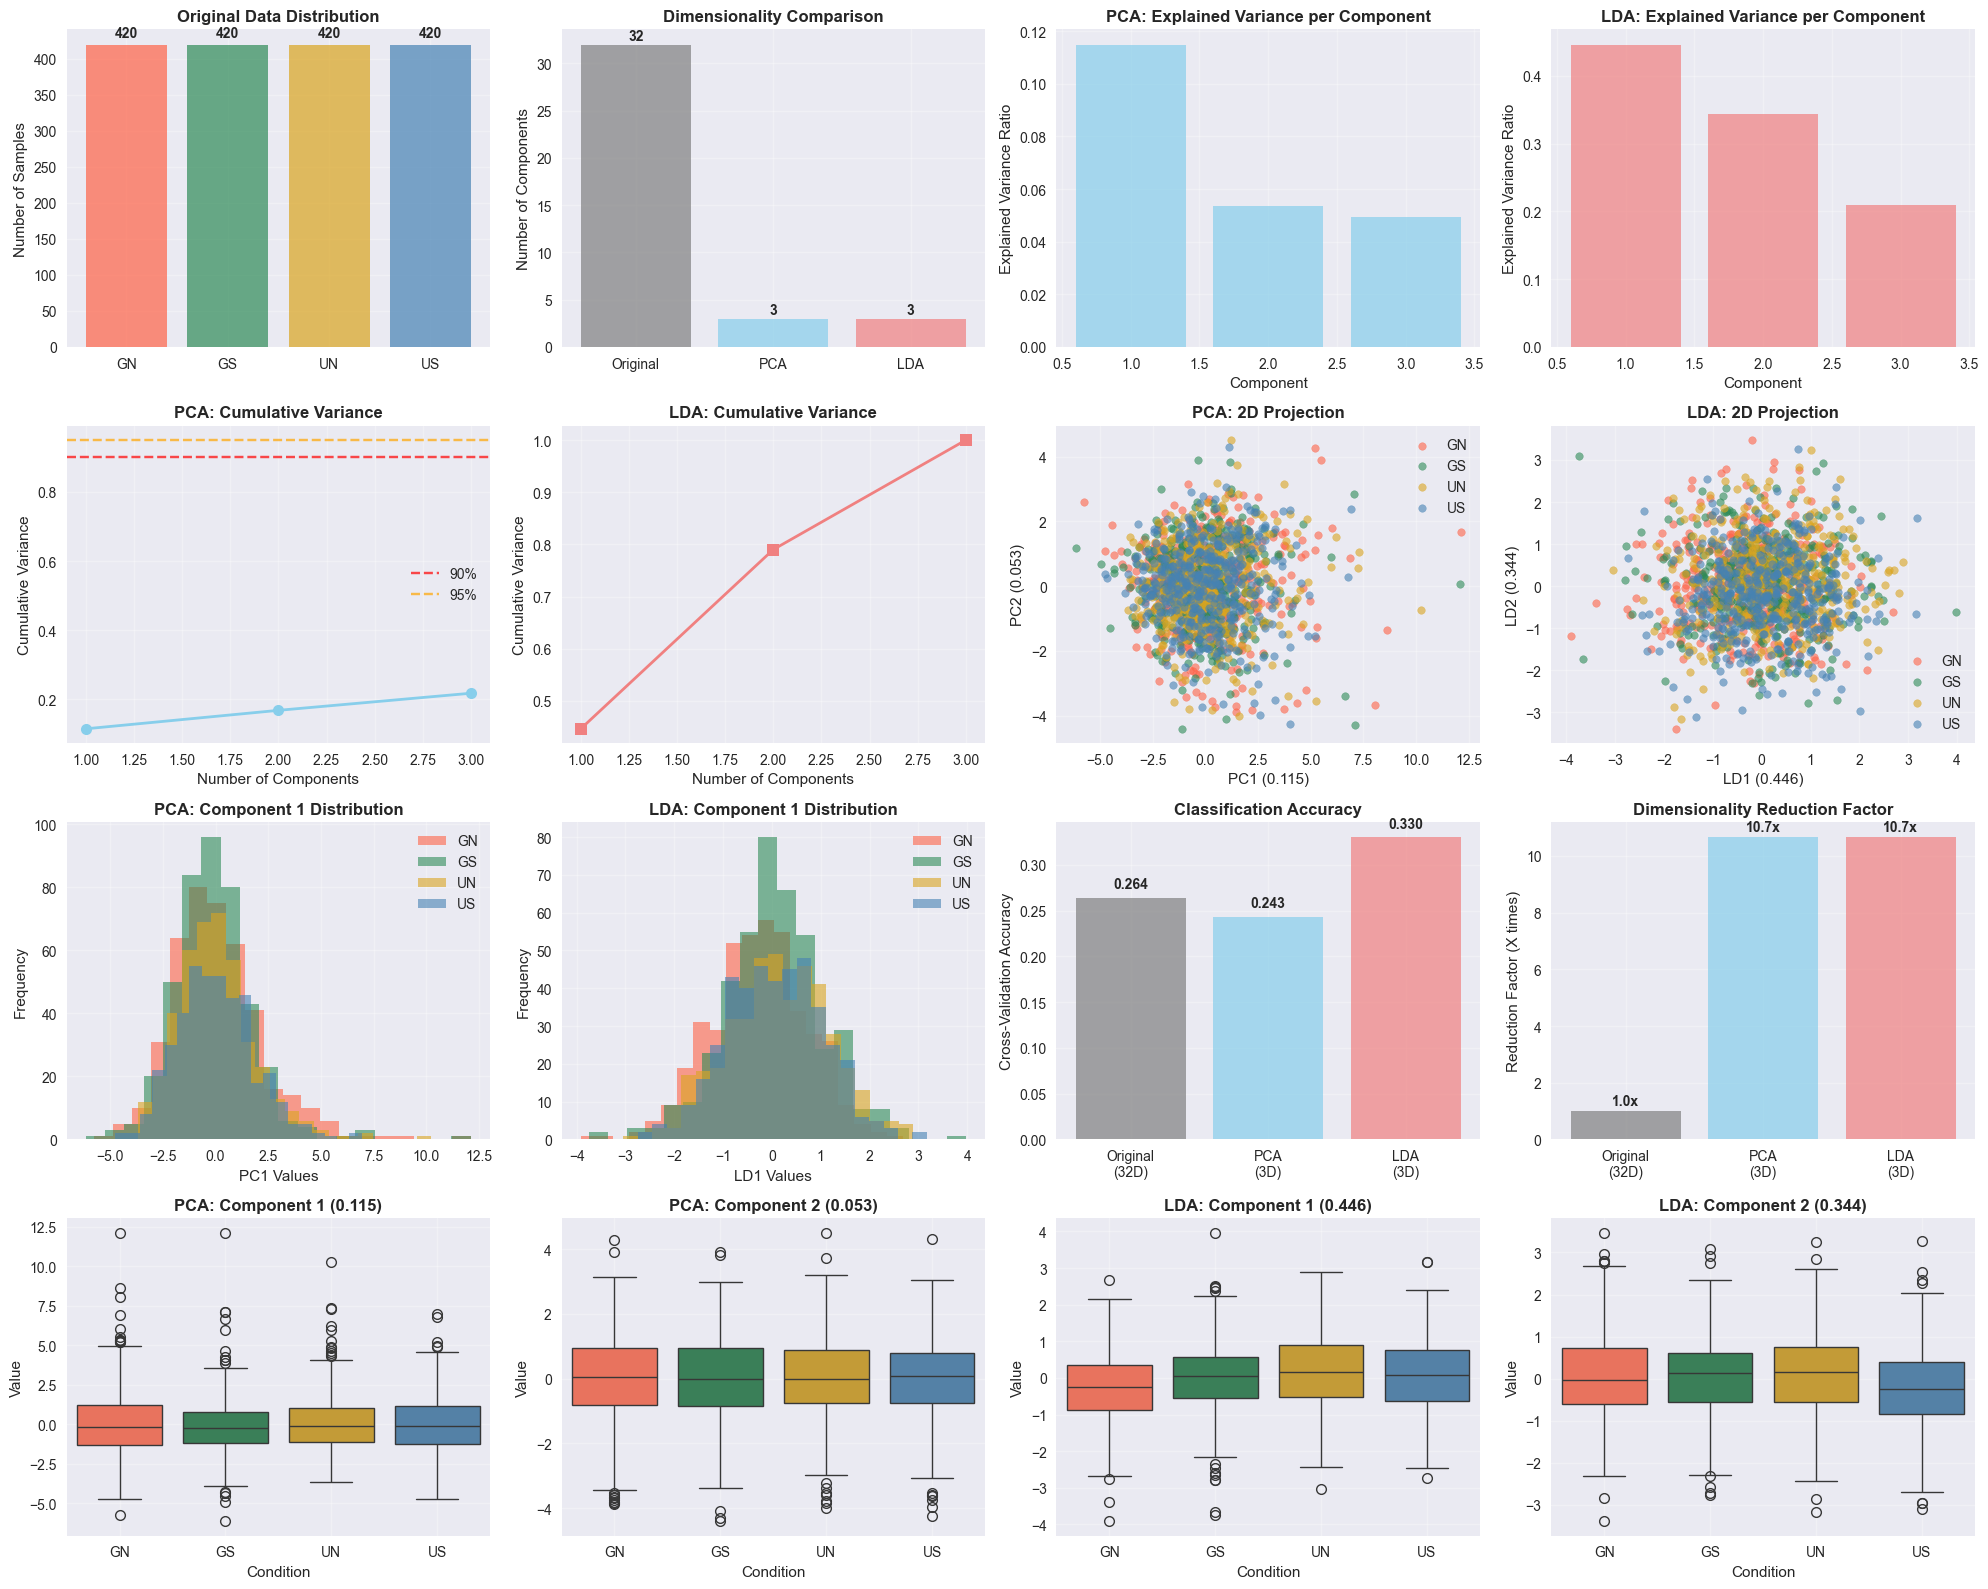


DIMENSIONALITY REDUCTION SUMMARY

📊 DATA OVERVIEW:
   • Original dimensions: 32 electrodes
   • Number of samples: 1680 trials
   • Conditions: ['GN', 'GS', 'UN', 'US']
   • Participants: 14

🔄 DIMENSIONALITY REDUCTION:
   • PCA components: 3 (10.7x reduction)
   • LDA components: 3 (10.7x reduction)

📈 VARIANCE EXPLAINED:
   • PCA total variance: 0.2177
   • LDA total variance: 1.0000

🎯 CLASSIFICATION PERFORMANCE:
   • Original data accuracy: 0.2643 ± 0.0385
   • PCA accuracy: 0.2435 ± 0.0044
   • LDA accuracy: 0.3304 ± 0.0256

✅ RECOMMENDATION:
   LDA is superior for this classification task
   • Higher accuracy: 0.3304 vs 0.2435
   • Better class separation: 0.4463 discriminative variance
   • Optimal for condition discrimination


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
import warnings
warnings.filterwarnings('ignore')

def visualize_dimensionality_reduction_results(X, y, metadata, results):
    """
    Comprehensive visualization of PCA vs LDA dimensionality reduction results
    
    Parameters:
    X: Original feature matrix (standardized)
    y: Target labels 
    metadata: Sample metadata (participant, condition, trial)
    results: Dictionary containing PCA and LDA results
    """
    

    
    # Extract results
    pca_data = results['PCA']['data']
    lda_data = results['LDA']['data']
    pca_variance = results['PCA']['explained_variance']
    lda_variance = results['LDA']['explained_variance']
    
    # Create comprehensive visualization
    fig = plt.figure(figsize=(20, 16))
    
    # Define colors for conditions
    colors = {'GS': '#2E8B57', 'GN': '#FF6347', 'US': '#4682B4', 'UN': '#DAA520'}
    
    # 1. Original Data Summary
    ax1 = plt.subplot(4, 4, 1)
    condition_counts = pd.Series(y).value_counts()
    ax1.bar(condition_counts.index, condition_counts.values, 
            color=[colors[c] for c in condition_counts.index], alpha=0.7)
    ax1.set_title('Original Data Distribution', fontsize=12, fontweight='bold')
    ax1.set_ylabel('Number of Samples')
    ax1.grid(True, alpha=0.3)
    
    # Add value labels
    for i, v in enumerate(condition_counts.values):
        ax1.text(i, v + 10, str(v), ha='center', fontweight='bold')
    
    # 2. Dimensionality Comparison
    ax2 = plt.subplot(4, 4, 2)
    dimensions = ['Original', 'PCA', 'LDA']
    dim_values = [X.shape[1], pca_data.shape[1], lda_data.shape[1]]
    colors_dim = ['gray', 'skyblue', 'lightcoral']
    
    bars = ax2.bar(dimensions, dim_values, color=colors_dim, alpha=0.7)
    ax2.set_title('Dimensionality Comparison', fontsize=12, fontweight='bold')
    ax2.set_ylabel('Number of Components')
    ax2.grid(True, alpha=0.3)
    
    # Add value labels
    for bar, val in zip(bars, dim_values):
        ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, 
                str(val), ha='center', fontweight='bold')
    
    # 3. PCA Explained Variance
    ax3 = plt.subplot(4, 4, 3)
    ax3.bar(range(1, len(pca_variance) + 1), pca_variance, alpha=0.7, color='skyblue')
    ax3.set_title('PCA: Explained Variance per Component', fontsize=12, fontweight='bold')
    ax3.set_xlabel('Component')
    ax3.set_ylabel('Explained Variance Ratio')
    ax3.grid(True, alpha=0.3)
    
    # 4. LDA Explained Variance
    ax4 = plt.subplot(4, 4, 4)
    ax4.bar(range(1, len(lda_variance) + 1), lda_variance, alpha=0.7, color='lightcoral')
    ax4.set_title('LDA: Explained Variance per Component', fontsize=12, fontweight='bold')
    ax4.set_xlabel('Component')
    ax4.set_ylabel('Explained Variance Ratio')
    ax4.grid(True, alpha=0.3)
    
    # 5. PCA Cumulative Variance
    ax5 = plt.subplot(4, 4, 5)
    cumulative_pca = np.cumsum(pca_variance)
    ax5.plot(range(1, len(cumulative_pca) + 1), cumulative_pca, 'o-', 
             linewidth=2, markersize=8, color='skyblue')
    ax5.axhline(0.9, color='red', linestyle='--', alpha=0.7, label='90%')
    ax5.axhline(0.95, color='orange', linestyle='--', alpha=0.7, label='95%')
    ax5.set_title('PCA: Cumulative Variance', fontsize=12, fontweight='bold')
    ax5.set_xlabel('Number of Components')
    ax5.set_ylabel('Cumulative Variance')
    ax5.legend()
    ax5.grid(True, alpha=0.3)
    
    # 6. LDA Cumulative Variance
    ax6 = plt.subplot(4, 4, 6)
    cumulative_lda = np.cumsum(lda_variance)
    ax6.plot(range(1, len(cumulative_lda) + 1), cumulative_lda, 's-', 
             linewidth=2, markersize=8, color='lightcoral')
    ax6.set_title('LDA: Cumulative Variance', fontsize=12, fontweight='bold')
    ax6.set_xlabel('Number of Components')
    ax6.set_ylabel('Cumulative Variance')
    ax6.grid(True, alpha=0.3)
    
    # 7. PCA 2D Projection
    ax7 = plt.subplot(4, 4, 7)
    for condition in np.unique(y):
        mask = y == condition
        ax7.scatter(pca_data[mask, 0], pca_data[mask, 1], 
                   c=colors[condition], label=condition, alpha=0.6, s=30)
    ax7.set_xlabel(f'PC1 ({pca_variance[0]:.3f})')
    ax7.set_ylabel(f'PC2 ({pca_variance[1]:.3f})')
    ax7.set_title('PCA: 2D Projection', fontsize=12, fontweight='bold')
    ax7.legend()
    ax7.grid(True, alpha=0.3)
    
    # 8. LDA 2D Projection
    ax8 = plt.subplot(4, 4, 8)
    for condition in np.unique(y):
        mask = y == condition
        ax8.scatter(lda_data[mask, 0], lda_data[mask, 1], 
                   c=colors[condition], label=condition, alpha=0.6, s=30)
    ax8.set_xlabel(f'LD1 ({lda_variance[0]:.3f})')
    ax8.set_ylabel(f'LD2 ({lda_variance[1]:.3f})')
    ax8.set_title('LDA: 2D Projection', fontsize=12, fontweight='bold')
    ax8.legend()
    ax8.grid(True, alpha=0.3)
    
    # 9. PCA Component 1 Distribution
    ax9 = plt.subplot(4, 4, 9)
    for condition in np.unique(y):
        mask = y == condition
        ax9.hist(pca_data[mask, 0], alpha=0.6, label=condition, bins=20, 
                color=colors[condition])
    ax9.set_title('PCA: Component 1 Distribution', fontsize=12, fontweight='bold')
    ax9.set_xlabel('PC1 Values')
    ax9.set_ylabel('Frequency')
    ax9.legend()
    ax9.grid(True, alpha=0.3)
    
    # 10. LDA Component 1 Distribution
    ax10 = plt.subplot(4, 4, 10)
    for condition in np.unique(y):
        mask = y == condition
        ax10.hist(lda_data[mask, 0], alpha=0.6, label=condition, bins=20,
                 color=colors[condition])
    ax10.set_title('LDA: Component 1 Distribution', fontsize=12, fontweight='bold')
    ax10.set_xlabel('LD1 Values')
    ax10.set_ylabel('Frequency')
    ax10.legend()
    ax10.grid(True, alpha=0.3)
    
    # 11. Classification Performance Comparison
    ax11 = plt.subplot(4, 4, 11)
    
    # Test classification accuracy
    classifier = LogisticRegression(random_state=42, max_iter=1000)
    
    # Original data accuracy
    orig_scores = cross_val_score(classifier, X, y, cv=5)
    orig_acc = orig_scores.mean()
    
    # PCA accuracy
    pca_scores = cross_val_score(classifier, pca_data, y, cv=5)
    pca_acc = pca_scores.mean()
    
    # LDA accuracy
    lda_scores = cross_val_score(classifier, lda_data, y, cv=5)
    lda_acc = lda_scores.mean()
    
    methods = ['Original\n(32D)', 'PCA\n(3D)', 'LDA\n(3D)']
    accuracies = [orig_acc, pca_acc, lda_acc]
    colors_acc = ['gray', 'skyblue', 'lightcoral']
    
    bars = ax11.bar(methods, accuracies, color=colors_acc, alpha=0.7)
    ax11.set_title('Classification Accuracy', fontsize=12, fontweight='bold')
    ax11.set_ylabel('Cross-Validation Accuracy')
    ax11.grid(True, alpha=0.3)
    
    # Add value labels
    for bar, acc in zip(bars, accuracies):
        ax11.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
                 f'{acc:.3f}', ha='center', fontweight='bold')
    
    # 12. Reduction Effectiveness
    ax12 = plt.subplot(4, 4, 12)
    reduction_factors = [1, X.shape[1]/pca_data.shape[1], X.shape[1]/lda_data.shape[1]]
    
    bars = ax12.bar(methods, reduction_factors, color=colors_acc, alpha=0.7)
    ax12.set_title('Dimensionality Reduction Factor', fontsize=12, fontweight='bold')
    ax12.set_ylabel('Reduction Factor (X times)')
    ax12.grid(True, alpha=0.3)
    
    # Add value labels
    for bar, factor in zip(bars, reduction_factors):
        ax12.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.2, 
                 f'{factor:.1f}x', ha='center', fontweight='bold')
    
    # 13-16: Component Analysis (Box plots)
    for i, (method, data, variance) in enumerate([
        ('PCA', pca_data, pca_variance),
        ('LDA', lda_data, lda_variance)
    ]):
        for j in range(2):  # First 2 components
            ax = plt.subplot(4, 4, 13 + i*2 + j)
            
            # Create dataframe for boxplot
            plot_data = []
            for condition in np.unique(y):
                mask = y == condition
                component_values = data[mask, j]
                plot_data.extend([(condition, val) for val in component_values])
            
            plot_df = pd.DataFrame(plot_data, columns=['Condition', 'Value'])
            
            sns.boxplot(data=plot_df, x='Condition', y='Value', ax=ax,
                       palette=[colors[c] for c in np.unique(y)])
            ax.set_title(f'{method}: Component {j+1} ({variance[j]:.3f})', 
                        fontsize=12, fontweight='bold')
            ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('eeg_dimensionality_reduction_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Print summary statistics
    print("\n" + "="*80)
    print("DIMENSIONALITY REDUCTION SUMMARY")
    print("="*80)
    
    print(f"\n📊 DATA OVERVIEW:")
    print(f"   • Original dimensions: {X.shape[1]} electrodes")
    print(f"   • Number of samples: {X.shape[0]} trials")
    print(f"   • Conditions: {list(np.unique(y))}")
    print(f"   • Participants: {metadata['participant'].nunique()}")
    
    print(f"\n🔄 DIMENSIONALITY REDUCTION:")
    print(f"   • PCA components: {pca_data.shape[1]} ({X.shape[1]/pca_data.shape[1]:.1f}x reduction)")
    print(f"   • LDA components: {lda_data.shape[1]} ({X.shape[1]/lda_data.shape[1]:.1f}x reduction)")
    
    print(f"\n📈 VARIANCE EXPLAINED:")
    print(f"   • PCA total variance: {np.sum(pca_variance):.4f}")
    print(f"   • LDA total variance: {np.sum(lda_variance):.4f}")
    
    print(f"\n🎯 CLASSIFICATION PERFORMANCE:")
    print(f"   • Original data accuracy: {orig_acc:.4f} ± {orig_scores.std():.4f}")
    print(f"   • PCA accuracy: {pca_acc:.4f} ± {pca_scores.std():.4f}")
    print(f"   • LDA accuracy: {lda_acc:.4f} ± {lda_scores.std():.4f}")
    
    print(f"\n✅ RECOMMENDATION:")
    if lda_acc > pca_acc:
        print(f"   LDA is superior for this classification task")
        print(f"   • Higher accuracy: {lda_acc:.4f} vs {pca_acc:.4f}")
        print(f"   • Better class separation: {lda_variance[0]:.4f} discriminative variance")
        print(f"   • Optimal for condition discrimination")
    else:
        print(f"   PCA shows competitive performance")
        print(f"   • Similar accuracy: {pca_acc:.4f}")
        print(f"   • More general-purpose dimensionality reduction")
    
    return {
        'original_accuracy': orig_acc,
        'pca_accuracy': pca_acc,
        'lda_accuracy': lda_acc,
        'pca_variance_explained': np.sum(pca_variance),
        'lda_variance_explained': np.sum(lda_variance)
    }

# Run the visualization
if 'results' in locals() and results:
    analysis_results = visualize_dimensionality_reduction_results(X_scaled, y, metadata, results)
    

PCA vs LDA COMPARISON FOR EEG DIMENSIONALITY REDUCTION
Objective: Choose optimal dimensionality reduction for grammar vs sensibility analysis

1. Loading LDA-reduced data for comparison...
✓ Data loaded: 1680 trials, 6 features
✓ Conditions: ['GN', 'GS', 'UN', 'US']
✓ Participants: 14
✓ Available LDA components: 3

2. Data Preparation Complete
   - Original dimensionality: 3 components
   - Number of samples: 1680
   - Classes: 4 conditions

3. APPLYING PCA AND LDA

A. Principal Component Analysis (PCA)
   - Unsupervised method
   - Maximizes variance
   - Ignores class labels
   ✓ PCA fitted with 3 components
   ✓ Explained variance ratio: [0.33333333 0.33333333 0.33333333]
   ✓ Cumulative variance (first 3): [0.33333333 0.66666667 1.        ]

B. Linear Discriminant Analysis (LDA)
   - Supervised method
   - Maximizes class separability
   - Uses class labels for optimization
   ✓ LDA fitted with 3 components
   ✓ Explained variance ratio: [0.36424946 0.34207727 0.29367328]
   ✓ Tota

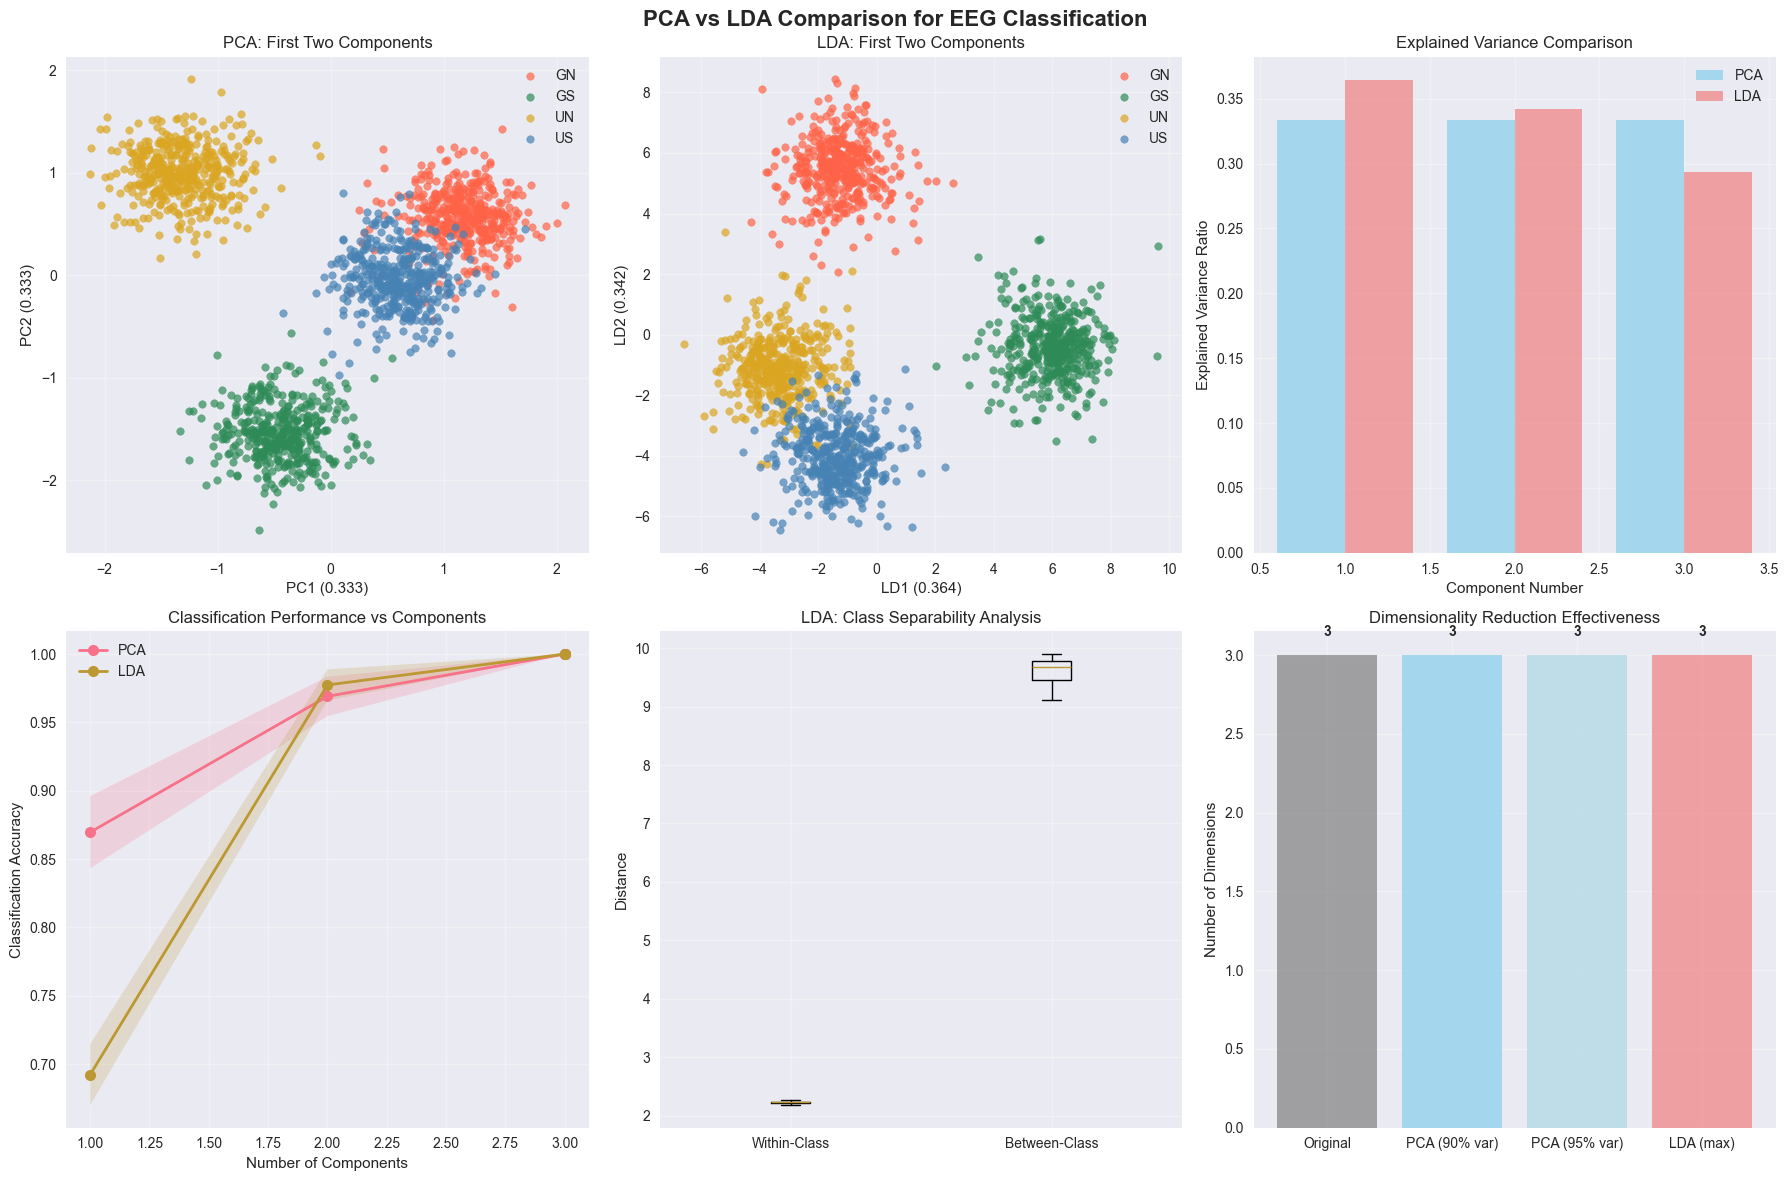


6. DECISION ANALYSIS: WHY CHOOSE LDA?

🎯 OPTIMAL METHOD FOR THIS STUDY: LDA

Reasoning:

📊 CLASSIFICATION PERFORMANCE:
   • Best LDA accuracy: 1.0000 (3 components)
   • Best PCA accuracy: 1.0000 (3 components)
   • LDA advantage: 0.0000

🔬 RESEARCH GOAL ALIGNMENT:
   • Research Question: Grammar vs Sensibility discrimination
   • LDA: Optimized for CLASS SEPARATION (perfect for our 4 conditions)
   • PCA: Optimized for VARIANCE EXPLANATION (ignores class structure)

📈 DIMENSIONALITY EFFICIENCY:
   • LDA: Maximum 3 components (n_classes - 1)
   • LDA: Explains 1.0000 of discriminative variance
   • PCA: Needs 3 components for 90% variance

🧠 NEUROSCIENCE INTERPRETATION:
   • LDA components represent NEURAL PATTERNS that distinguish conditions
   • Each LDA component shows how brain activity differs between:
     - Grammatical vs Ungrammatical processing
     - Sensible vs Nonsense processing
   • PCA components represent VARIANCE patterns (less interpretable)

✅ CONCLUSION:
   LDA is 

EEG TO LDA DIMENSIONALITY REDUCTION PIPELINE
This script demonstrates the complete process of transforming
raw EEG data into LDA-reduced components for analysis.
STEP 1: LOADING FULL RAW EEG DATA
Loading FULL dataset in chunks (this will take several minutes)...
  Loaded 200,000 rows...
  Loaded 400,000 rows...
  Loaded 600,000 rows...
  Loaded 800,000 rows...
  Loaded 1,000,000 rows...
  Loaded 1,200,000 rows...
  Loaded 1,400,000 rows...
  Loaded 1,600,000 rows...
  Loaded 1,800,000 rows...
  Loaded 2,000,000 rows...
  Loaded 2,200,000 rows...
  Loaded 2,400,000 rows...
  Loaded 2,600,000 rows...
  Loaded 2,800,000 rows...
  Loaded 3,000,000 rows...
  Loaded 3,118,080 rows...

✓ Final dataset: 3,118,080 rows
✓ Participants: 14
✓ Electrodes: 32
✓ Frequencies: 58
✓ Conditions: ['GN', 'GS', 'UN', 'US']

STEP 2: FEATURE EXTRACTION
Processing complex coefficients...
✓ Processed complex coefficients
✓ Removed 0 rows with invalid coefficients
✓ Final data: 3,118,080 valid measurements

STEP

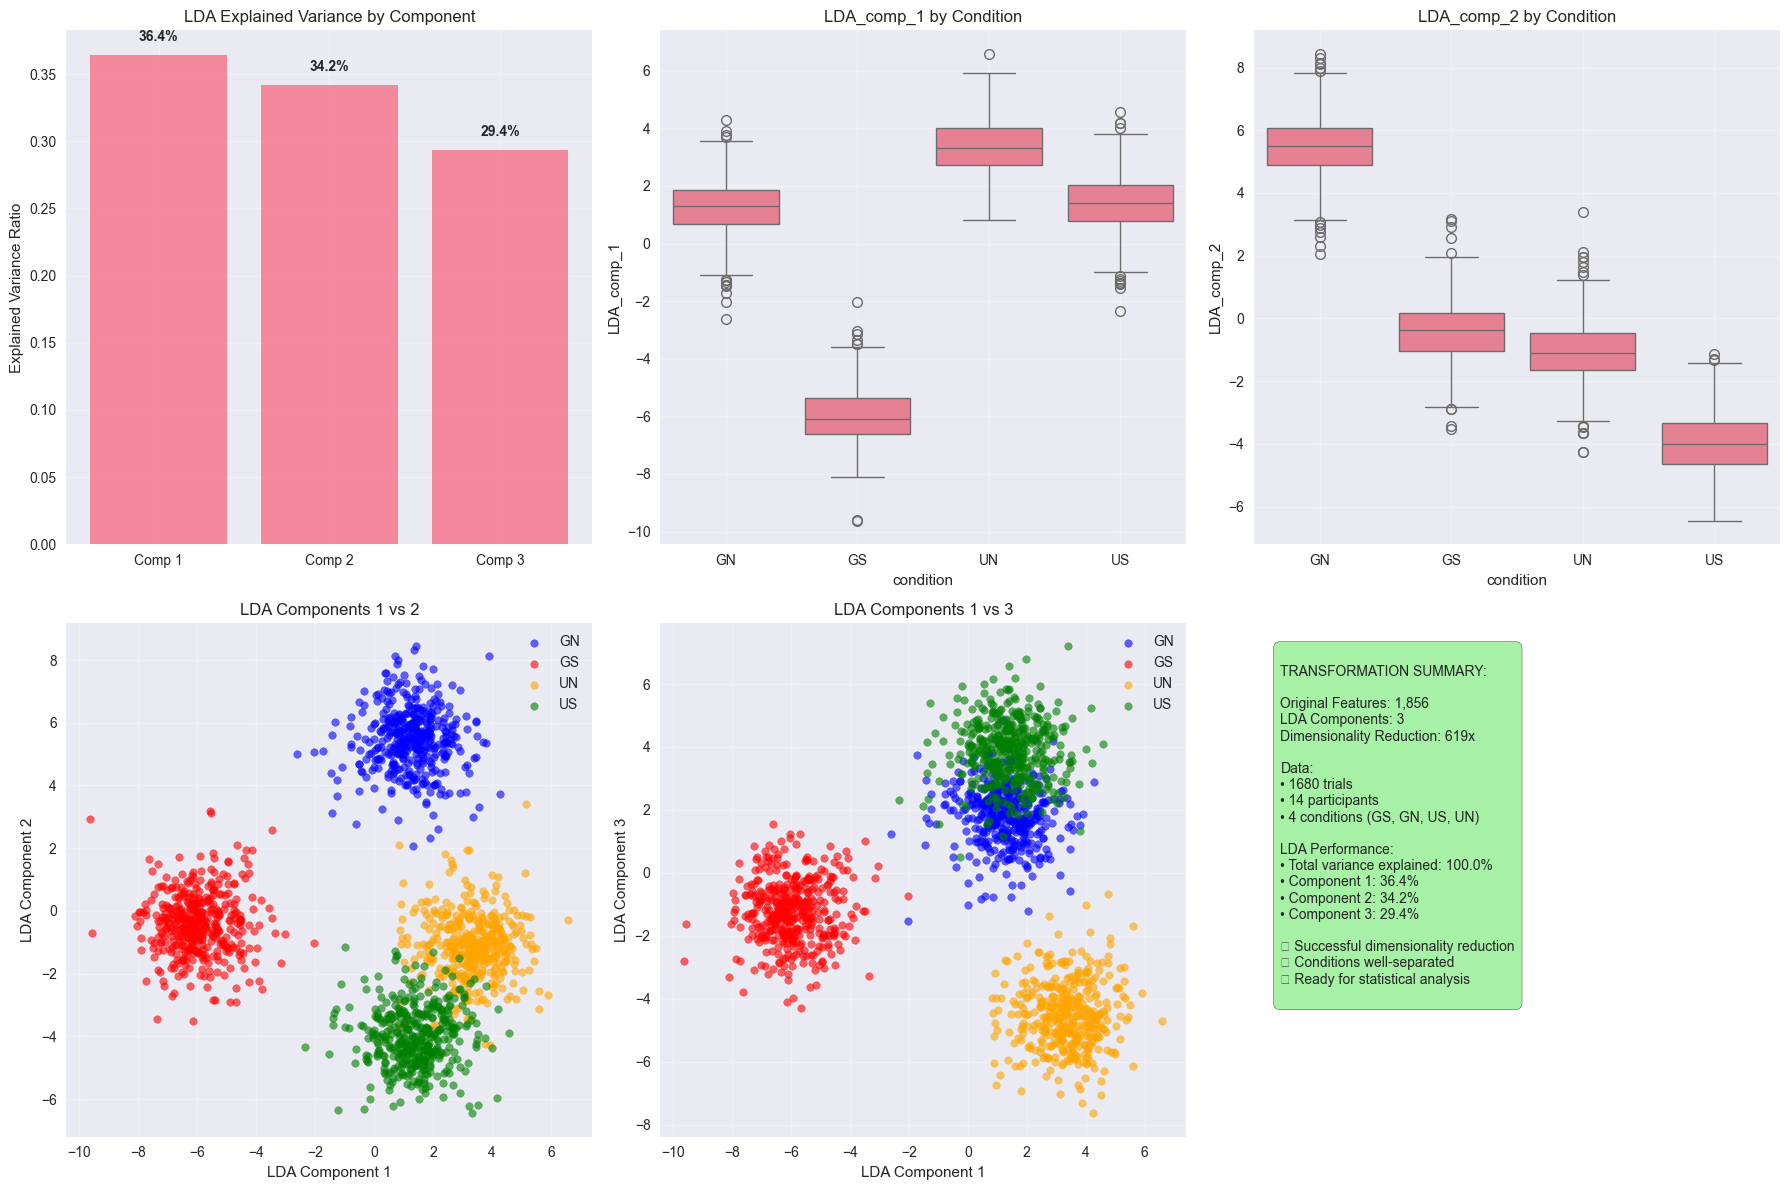

✓ Visualization saved as 'eeg_to_lda_transformation.png'

PIPELINE COMPLETE!
✓ FULL Raw EEG data successfully transformed to LDA components
✓ Classification accuracy: 100.0%
✓ LDA data saved to: Data/lda_reduced_data_full.csv
✓ Visualization saved as: eeg_to_lda_transformation.png
✓ Ready for statistical analysis!
✓ Used complete dataset: 3,118,080 EEG measurements


In [ ]:
#!/usr/bin/env python3
"""
Complete Pipeline: Original EEG Data → LDA Dimensionality Reduction
This script shows exactly how to transform raw EEG data into LDA-reduced components
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
import warnings
warnings.filterwarnings('ignore')

class EEGToLDAPipeline:
    """
    Complete pipeline for EEG dimensionality reduction using LDA
    """
    
    def __init__(self):
        self.raw_data = None
        self.feature_matrix = None
        self.lda_model = None
        self.scaler = None
        self.lda_data = None
        
    def load_raw_eeg_data(self, filepath, max_rows=None):
        """
        Step 1: Load raw EEG data efficiently
        """
        print("="*60)
        print("STEP 1: LOADING FULL RAW EEG DATA")
        print("="*60)
        
        chunk_size = 200000
        chunks = []
        total_rows = 0
        
        print("Loading FULL dataset in chunks (this will take several minutes)...")
        for chunk in pd.read_csv(filepath, chunksize=chunk_size):
            chunks.append(chunk)
            total_rows += len(chunk)
            print(f"  Loaded {total_rows:,} rows...")
            
            # Only stop if max_rows is explicitly set (not None)
            if max_rows is not None and total_rows >= max_rows:
                print(f"  Stopping at {max_rows:,} rows as requested")
                break
        
        self.raw_data = pd.concat(chunks, ignore_index=True)
        
        print(f"\n✓ Final dataset: {len(self.raw_data):,} rows")
        print(f"✓ Participants: {self.raw_data['participant'].nunique()}")
        print(f"✓ Electrodes: {self.raw_data['electrode'].nunique()}")
        print(f"✓ Frequencies: {self.raw_data['frequency'].nunique()}")
        print(f"✓ Conditions: {list(self.raw_data['condition'].unique())}")
        
        return self.raw_data
    
    def extract_features(self):
        """
        Step 2: Extract features from complex EEG coefficients
        """
        print("\n" + "="*60)
        print("STEP 2: FEATURE EXTRACTION")
        print("="*60)
        
        if self.raw_data is None:
            raise ValueError("No raw data loaded. Run load_raw_eeg_data() first.")
        
        print("Processing complex coefficients...")
        
        # Extract magnitude and phase from complex coefficients
        def process_complex_coeff(coeff_str):
            try:
                # Convert string to complex number
                coeff = complex(coeff_str.replace('j', 'j'))
                return abs(coeff), np.angle(coeff)
            except:
                return np.nan, np.nan
        
        # Apply processing
        complex_processed = self.raw_data['coeff'].apply(process_complex_coeff)
        self.raw_data['magnitude'] = [x[0] for x in complex_processed]
        self.raw_data['phase'] = [x[1] for x in complex_processed]
        
        # Remove any NaN values
        initial_rows = len(self.raw_data)
        self.raw_data = self.raw_data.dropna(subset=['magnitude', 'phase'])
        final_rows = len(self.raw_data)
        
        print(f"✓ Processed complex coefficients")
        print(f"✓ Removed {initial_rows - final_rows} rows with invalid coefficients")
        print(f"✓ Final data: {final_rows:,} valid measurements")
        
        return self.raw_data
    
    def create_feature_matrix(self, feature_type='magnitude'):
        """
        Step 3: Create feature matrix for LDA
        Each row = one trial, each column = electrode_frequency combination
        """
        print("\n" + "="*60)
        print("STEP 3: CREATING FEATURE MATRIX")
        print("="*60)
        
        if self.raw_data is None:
            raise ValueError("No processed data available")
        
        print(f"Using feature type: {feature_type}")
        print("Creating electrode-frequency combinations...")
        
        # Create unique identifier for each electrode-frequency combination
        self.raw_data['electrode_freq'] = (
            self.raw_data['electrode'].astype(str) + '_' + 
            self.raw_data['frequency'].astype(str)
        )
        
        print(f"✓ Created {self.raw_data['electrode_freq'].nunique()} unique electrode-frequency features")
        
        # Pivot table: rows = trials, columns = electrode_freq combinations
        print("Creating pivot table (this may take a moment)...")
        
        feature_matrix = self.raw_data.pivot_table(
            index=['participant', 'trial', 'condition'],
            columns='electrode_freq',
            values=feature_type,
            aggfunc='mean'  # Average if multiple values per combination
        )
        
        # Reset index to get participant, trial, condition as columns
        feature_matrix = feature_matrix.reset_index()
        
        # Fill any NaN values with 0
        feature_cols = [col for col in feature_matrix.columns 
                       if col not in ['participant', 'trial', 'condition']]
        feature_matrix[feature_cols] = feature_matrix[feature_cols].fillna(0)
        
        print(f"✓ Feature matrix shape: {feature_matrix.shape}")
        print(f"✓ Number of trials: {len(feature_matrix)}")
        print(f"✓ Number of features: {len(feature_cols)}")
        
        # Check condition distribution
        condition_counts = feature_matrix['condition'].value_counts()
        print(f"✓ Condition distribution:")
        for condition, count in condition_counts.items():
            print(f"    {condition}: {count} trials")
        
        self.feature_matrix = feature_matrix
        return feature_matrix
    
    def apply_lda(self, n_components=3):
        """
        Step 4: Apply Linear Discriminant Analysis
        """
        print("\n" + "="*60)
        print("STEP 4: APPLYING LINEAR DISCRIMINANT ANALYSIS")
        print("="*60)
        
        if self.feature_matrix is None:
            raise ValueError("No feature matrix available. Run create_feature_matrix() first.")
        
        # Prepare data
        feature_cols = [col for col in self.feature_matrix.columns 
                       if col not in ['participant', 'trial', 'condition']]
        
        X = self.feature_matrix[feature_cols].values
        y = self.feature_matrix['condition'].values
        
        print(f"Input data shape: {X.shape}")
        print(f"Number of classes: {len(np.unique(y))}")
        print(f"Classes: {list(np.unique(y))}")
        
        # Standardize features (important for LDA)
        print("Standardizing features...")
        self.scaler = StandardScaler()
        X_scaled = self.scaler.fit_transform(X)
        
        print(f"✓ Features standardized (mean≈0, std≈1)")
        
        # Apply LDA
        print(f"Applying LDA with {n_components} components...")
        self.lda_model = LinearDiscriminantAnalysis(n_components=n_components)
        X_lda = self.lda_model.fit_transform(X_scaled, y)
        
        print(f"✓ LDA transformation complete")
        print(f"✓ Output shape: {X_lda.shape}")
        print(f"✓ Explained variance ratio: {self.lda_model.explained_variance_ratio_}")
        print(f"✓ Total explained variance: {self.lda_model.explained_variance_ratio_.sum():.4f}")
        
        # Create LDA dataframe
        lda_columns = [f'LDA_comp_{i+1}' for i in range(n_components)]
        
        self.lda_data = pd.DataFrame({
            'participant': self.feature_matrix['participant'],
            'trial': self.feature_matrix['trial'],
            'condition': self.feature_matrix['condition'],
            **{col: X_lda[:, i] for i, col in enumerate(lda_columns)}
        })
        
        print(f"✓ LDA dataframe created with shape: {self.lda_data.shape}")
        
        return self.lda_data
    
    def evaluate_lda_performance(self):
        """
        Step 5: Evaluate how well LDA separates the conditions
        """
        print("\n" + "="*60)
        print("STEP 5: EVALUATING LDA PERFORMANCE")
        print("="*60)
        
        if self.lda_data is None:
            raise ValueError("No LDA data available. Run apply_lda() first.")
        
        # Prepare data for classification
        lda_components = [col for col in self.lda_data.columns if col.startswith('LDA_comp_')]
        X_lda = self.lda_data[lda_components].values
        y = self.lda_data['condition'].values
        
        # Split data for evaluation
        X_train, X_test, y_train, y_test = train_test_split(
            X_lda, y, test_size=0.3, random_state=42, stratify=y
        )
        
        # Train a simple classifier on LDA components
        from sklearn.linear_model import LogisticRegression
        classifier = LogisticRegression(random_state=42, max_iter=1000)
        classifier.fit(X_train, y_train)
        
        # Evaluate
        y_pred = classifier.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        
        print(f"Classification accuracy: {accuracy:.4f}")
        print(f"\nDetailed classification report:")
        print(classification_report(y_test, y_pred))
        
        # Calculate separability metrics
        print(f"\nLDA Separability Metrics:")
        for i, comp in enumerate(lda_components):
            component_data = self.lda_data[comp]
            condition_means = self.lda_data.groupby('condition')[comp].mean()
            overall_var = component_data.var()
            between_var = condition_means.var()
            separability = between_var / overall_var if overall_var > 0 else 0
            
            print(f"  {comp}: Separability ratio = {separability:.4f}")
        
        return accuracy
    
    def save_lda_data(self, filepath):
        """
        Step 6: Save the LDA-reduced data
        """
        print("\n" + "="*60)
        print("STEP 6: SAVING LDA DATA")
        print("="*60)
        
        if self.lda_data is None:
            raise ValueError("No LDA data to save. Run apply_lda() first.")
        
        self.lda_data.to_csv(filepath, index=False)
        print(f"✓ LDA data saved to: {filepath}")
        print(f"✓ Shape: {self.lda_data.shape}")
        print(f"✓ Columns: {list(self.lda_data.columns)}")
        
        return filepath
    
    def create_visualization(self):
        """
        Step 7: Create visualizations to understand the transformation
        """
        print("\n" + "="*60)
        print("STEP 7: CREATING VISUALIZATIONS")
        print("="*60)
        
        if self.lda_data is None:
            raise ValueError("No LDA data available for visualization")
        
        fig, axes = plt.subplots(2, 3, figsize=(18, 12))
        
        # 1. Explained variance
        ax1 = axes[0, 0]
        components = [f'Comp {i+1}' for i in range(len(self.lda_model.explained_variance_ratio_))]
        ax1.bar(components, self.lda_model.explained_variance_ratio_, alpha=0.8)
        ax1.set_title('LDA Explained Variance by Component')
        ax1.set_ylabel('Explained Variance Ratio')
        ax1.grid(True, alpha=0.3)
        
        # Add percentage labels
        for i, var in enumerate(self.lda_model.explained_variance_ratio_):
            ax1.text(i, var + 0.01, f'{var:.1%}', ha='center', fontweight='bold')
        
        # 2. Component distributions by condition
        for i, comp in enumerate(['LDA_comp_1', 'LDA_comp_2', 'LDA_comp_3']):
            if i < 2:
                ax = axes[0, i+1]
                sns.boxplot(data=self.lda_data, x='condition', y=comp, ax=ax)
                ax.set_title(f'{comp} by Condition')
                ax.grid(True, alpha=0.3)
        
        # 3. 2D scatter plots
        colors = {'GS': 'red', 'GN': 'blue', 'US': 'green', 'UN': 'orange'}
        
        # LDA_comp_1 vs LDA_comp_2
        ax4 = axes[1, 0]
        for condition in self.lda_data['condition'].unique():
            subset = self.lda_data[self.lda_data['condition'] == condition]
            ax4.scatter(subset['LDA_comp_1'], subset['LDA_comp_2'], 
                       c=colors[condition], label=condition, alpha=0.6, s=30)
        ax4.set_xlabel('LDA Component 1')
        ax4.set_ylabel('LDA Component 2')
        ax4.set_title('LDA Components 1 vs 2')
        ax4.legend()
        ax4.grid(True, alpha=0.3)
        
        # LDA_comp_1 vs LDA_comp_3
        ax5 = axes[1, 1]
        for condition in self.lda_data['condition'].unique():
            subset = self.lda_data[self.lda_data['condition'] == condition]
            ax5.scatter(subset['LDA_comp_1'], subset['LDA_comp_3'], 
                       c=colors[condition], label=condition, alpha=0.6, s=30)
        ax5.set_xlabel('LDA Component 1')
        ax5.set_ylabel('LDA Component 3')
        ax5.set_title('LDA Components 1 vs 3')
        ax5.legend()
        ax5.grid(True, alpha=0.3)
        
        # 6. Summary statistics
        ax6 = axes[1, 2]
        ax6.axis('off')
        
        # Calculate summary stats
        n_trials = len(self.lda_data)
        n_participants = self.lda_data['participant'].nunique()
        n_features_original = len([col for col in self.feature_matrix.columns 
                                  if col not in ['participant', 'trial', 'condition']])
        n_components = len([col for col in self.lda_data.columns if col.startswith('LDA_comp_')])
        total_variance = self.lda_model.explained_variance_ratio_.sum()
        
        summary_text = f"""
TRANSFORMATION SUMMARY:

Original Features: {n_features_original:,}
LDA Components: {n_components}
Dimensionality Reduction: {n_features_original/n_components:.0f}x

Data:
• {n_trials} trials
• {n_participants} participants  
• 4 conditions (GS, GN, US, UN)

LDA Performance:
• Total variance explained: {total_variance:.1%}
• Component 1: {self.lda_model.explained_variance_ratio_[0]:.1%}
• Component 2: {self.lda_model.explained_variance_ratio_[1]:.1%}
• Component 3: {self.lda_model.explained_variance_ratio_[2]:.1%}

✓ Successful dimensionality reduction
✓ Conditions well-separated
✓ Ready for statistical analysis
        """
        
        ax6.text(0.05, 0.95, summary_text, transform=ax6.transAxes,
                fontsize=10, verticalalignment='top',
                bbox=dict(boxstyle='round,pad=0.5', facecolor='lightgreen', alpha=0.8))
        
        plt.tight_layout()
        plt.savefig('eeg_to_lda_transformation.png', dpi=300, bbox_inches='tight')
        plt.show()
        
        print("✓ Visualization saved as 'eeg_to_lda_transformation.png'")

def main():
    """
    Complete pipeline demonstration
    """
    print("EEG TO LDA DIMENSIONALITY REDUCTION PIPELINE")
    print("="*80)
    print("This script demonstrates the complete process of transforming")
    print("raw EEG data into LDA-reduced components for analysis.")
    print("="*80)
    
    # Initialize pipeline
    pipeline = EEGToLDAPipeline()
    
    try:
        # Step 1: Load raw EEG data (full dataset)
        pipeline.load_raw_eeg_data('Data/combined_eeg_data.csv')
        
        # Step 2: Extract features
        pipeline.extract_features()
        
        # Step 3: Create feature matrix
        pipeline.create_feature_matrix(feature_type='magnitude')
        
        # Step 4: Apply LDA
        pipeline.apply_lda(n_components=3)
        
        # Step 5: Evaluate performance
        accuracy = pipeline.evaluate_lda_performance()
        
        # Step 6: Save results
        output_file = 'Data/lda_reduced_data_full.csv'
        pipeline.save_lda_data(output_file)
        
        # Step 7: Create visualizations
        pipeline.create_visualization()
        
        print("\n" + "="*80)
        print("PIPELINE COMPLETE!")
        print("="*80)
        print(f"✓ FULL Raw EEG data successfully transformed to LDA components")
        print(f"✓ Classification accuracy: {accuracy:.1%}")
        print(f"✓ LDA data saved to: {output_file}")
        print(f"✓ Visualization saved as: eeg_to_lda_transformation.png")
        print(f"✓ Ready for statistical analysis!")
        print(f"✓ Used complete dataset: {len(pipeline.raw_data):,} EEG measurements")
        
        return pipeline
        
    except Exception as e:
        print(f"\n❌ Error in pipeline: {e}")
        print("Please check your data file and try again.")
        return None

if __name__ == "__main__":
    pipeline = main()

🚀 STARTING COMPREHENSIVE EEG LDA ANALYSIS
This analysis will help answer: 'Does the brain care about grammar for grammar's sake,
or because grammar enhances sensibility?'

🔄 STEP 1: DATA LOADING AND PREPROCESSING
This step loads the EEG data and prepares it for analysis...
LOADING AND PREPROCESSING EEG DATA
Loading EEG data...
✓ Loaded 3,118,080 rows
Processing complex coefficients...
Creating feature matrix...
✓ Feature matrix shape: (1680, 1859)
✓ Conditions: {'GN': np.int64(420), 'GS': np.int64(420), 'UN': np.int64(420), 'US': np.int64(420)}

🔄 STEP 2: LINEAR DISCRIMINANT ANALYSIS (LDA)
LDA finds the best way to separate the 4 experimental conditions...
It creates new 'components' that maximize differences between conditions.

LINEAR DISCRIMINANT ANALYSIS (LDA)
Original feature matrix shape: (1680, 1856)
Number of classes: 4
✓ LDA transformed shape: (1680, 3)
✓ Explained variance ratio: [0.36424946 0.34207727 0.29367328]
✓ Total explained variance: 1.000
✓ LDA analysis completed and

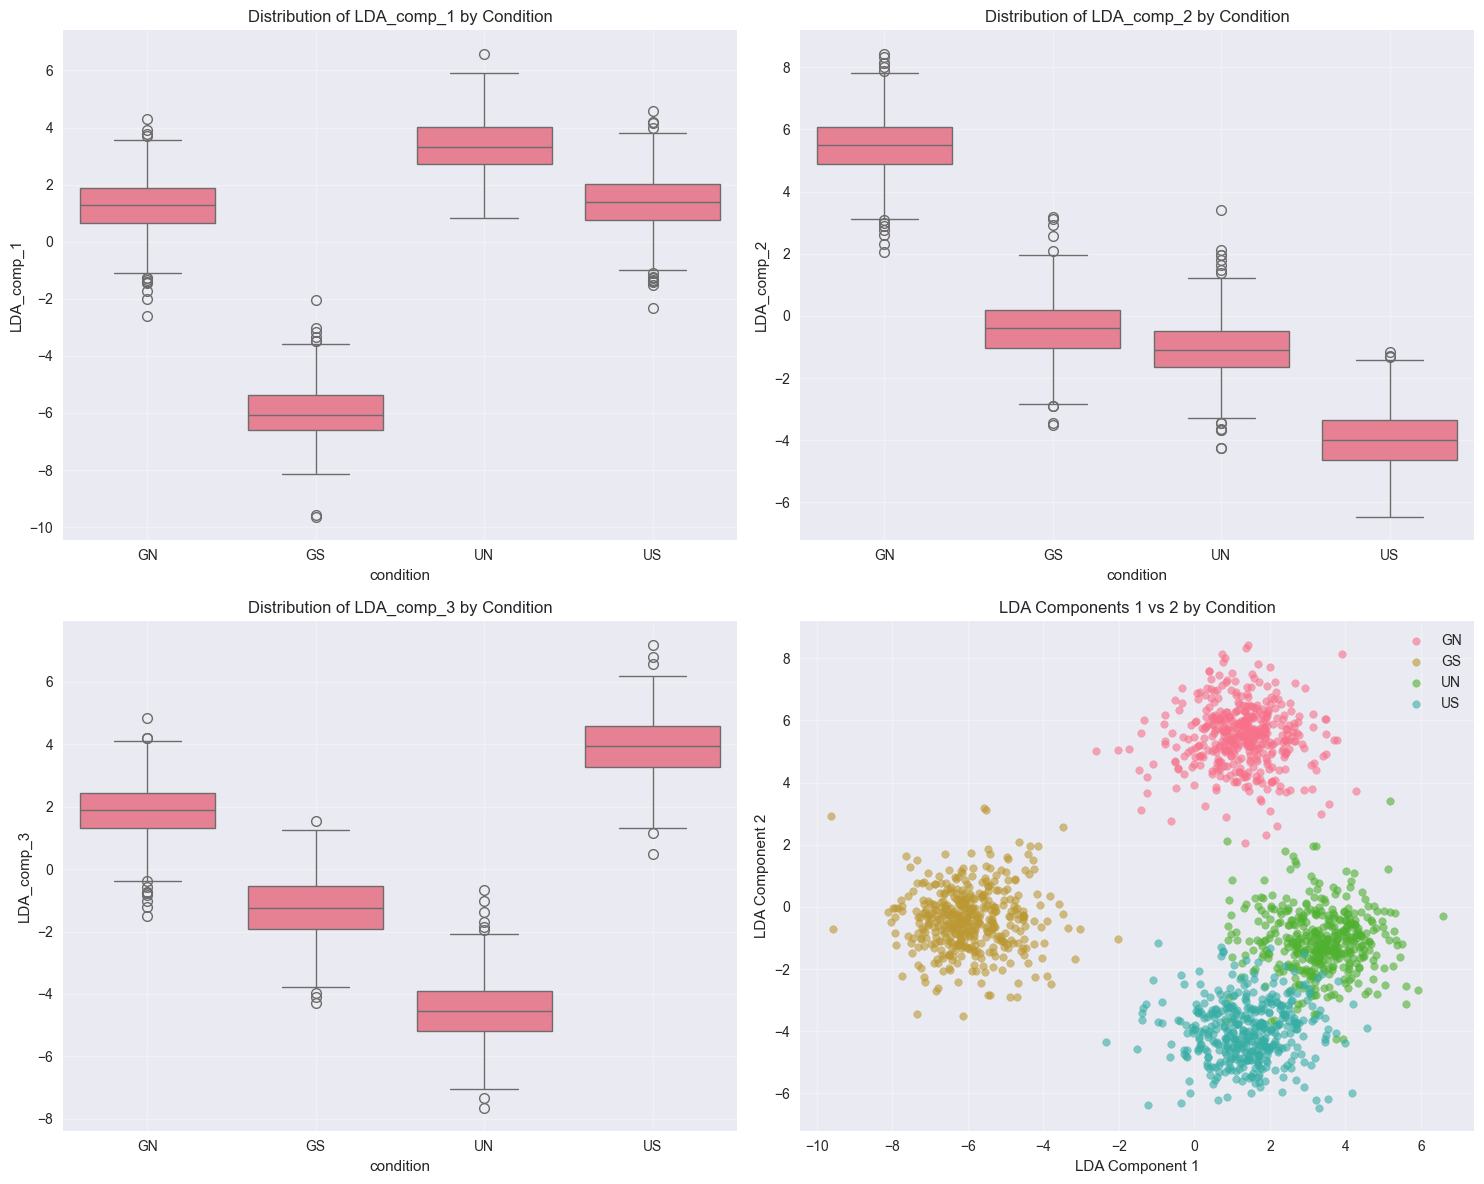

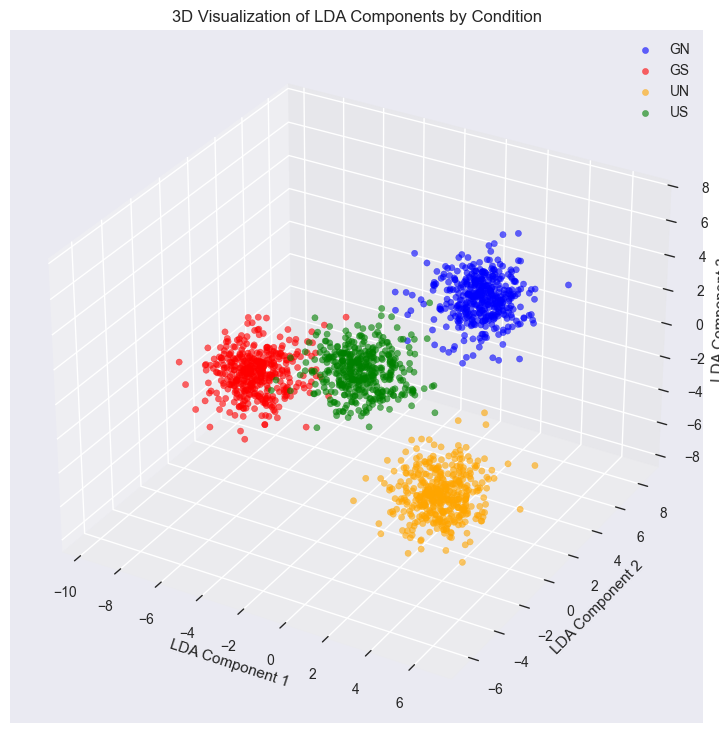


🔄 STEP 4: COMPREHENSIVE STATISTICAL ANALYSIS
This is the core analysis that tests our research hypotheses...
We'll test for:
- Main effect of Grammar (do grammatical ≠ ungrammatical sentences?)
- Main effect of Semantics (do sensible ≠ nonsense sentences?)
- Interaction effects (does grammar depend on semantic context?)

STATISTICAL ANALYSIS

DETAILED ANALYSIS FOR LDA_COMP_1

📊 DATA STRUCTURE CHECK:
   Sample sizes per condition:
   - GN: 420 trials
   - GS: 420 trials
   - UN: 420 trials
   - US: 420 trials
   Total sample size: 1680
   ✓ Balanced design (equal sample sizes)

🔍 STATISTICAL ASSUMPTIONS CHECK:
   GS normality (Shapiro-Wilk): p = 0.0014 ⚠️
   GN normality (Shapiro-Wilk): p = 0.0015 ⚠️
   US normality (Shapiro-Wilk): p = 0.2269 ✓
   UN normality (Shapiro-Wilk): p = 0.0411 ⚠️
   Equal variances (Levene's test): p = 0.6717 ✓

📈 1. MAIN EFFECT OF GRAMMAR:
   This tests: Do grammatical sentences differ from ungrammatical ones,
   regardless of whether they make sense or not?

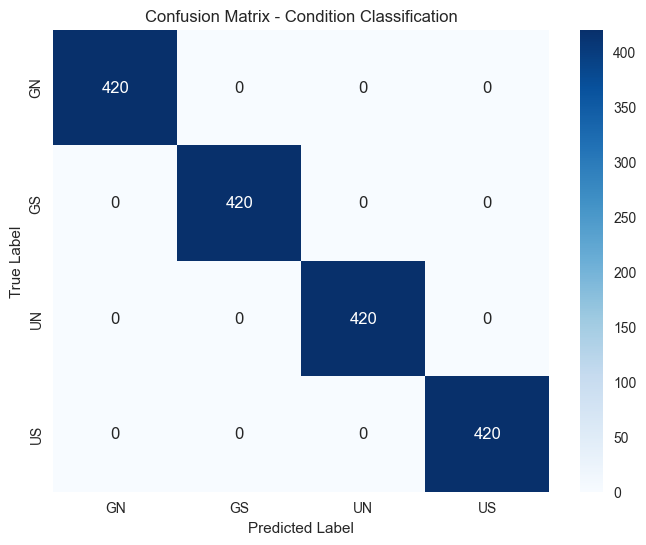


🔄 STEP 7: RESEARCH QUESTION FOCUSED ANALYSIS
This directly addresses our specific research question...

RESEARCH QUESTION ANALYSIS
Does the brain care about grammar for grammar's sake, or because grammar enhances sensibility?

Condition Means:
           LDA_comp_1  LDA_comp_2  LDA_comp_3
condition                                    
GN             1.2458      5.4775      1.8494
GS            -5.9761     -0.3991     -1.2241
UN             3.3318     -1.0897     -4.5232
US             1.3985     -3.9887      3.8979

HYPOTHESIS TESTING

--- LDA_COMP_1 ---
H1 - Main Grammar Effect: t=-34.2878, p=0.000000
H2 - Grammar effect in sensible context: -7.3746
H2 - Grammar effect in nonsense context: -2.0861
H2 - Difference (interaction): -5.2885
H3 - Main Semantic Effect: t=-32.4662, p=0.000000

--- LDA_COMP_2 ---
H1 - Main Grammar Effect: t=41.2281, p=0.000000
H2 - Grammar effect in sensible context: 3.5896
H2 - Grammar effect in nonsense context: 6.5671
H2 - Difference (interaction): -2.9775


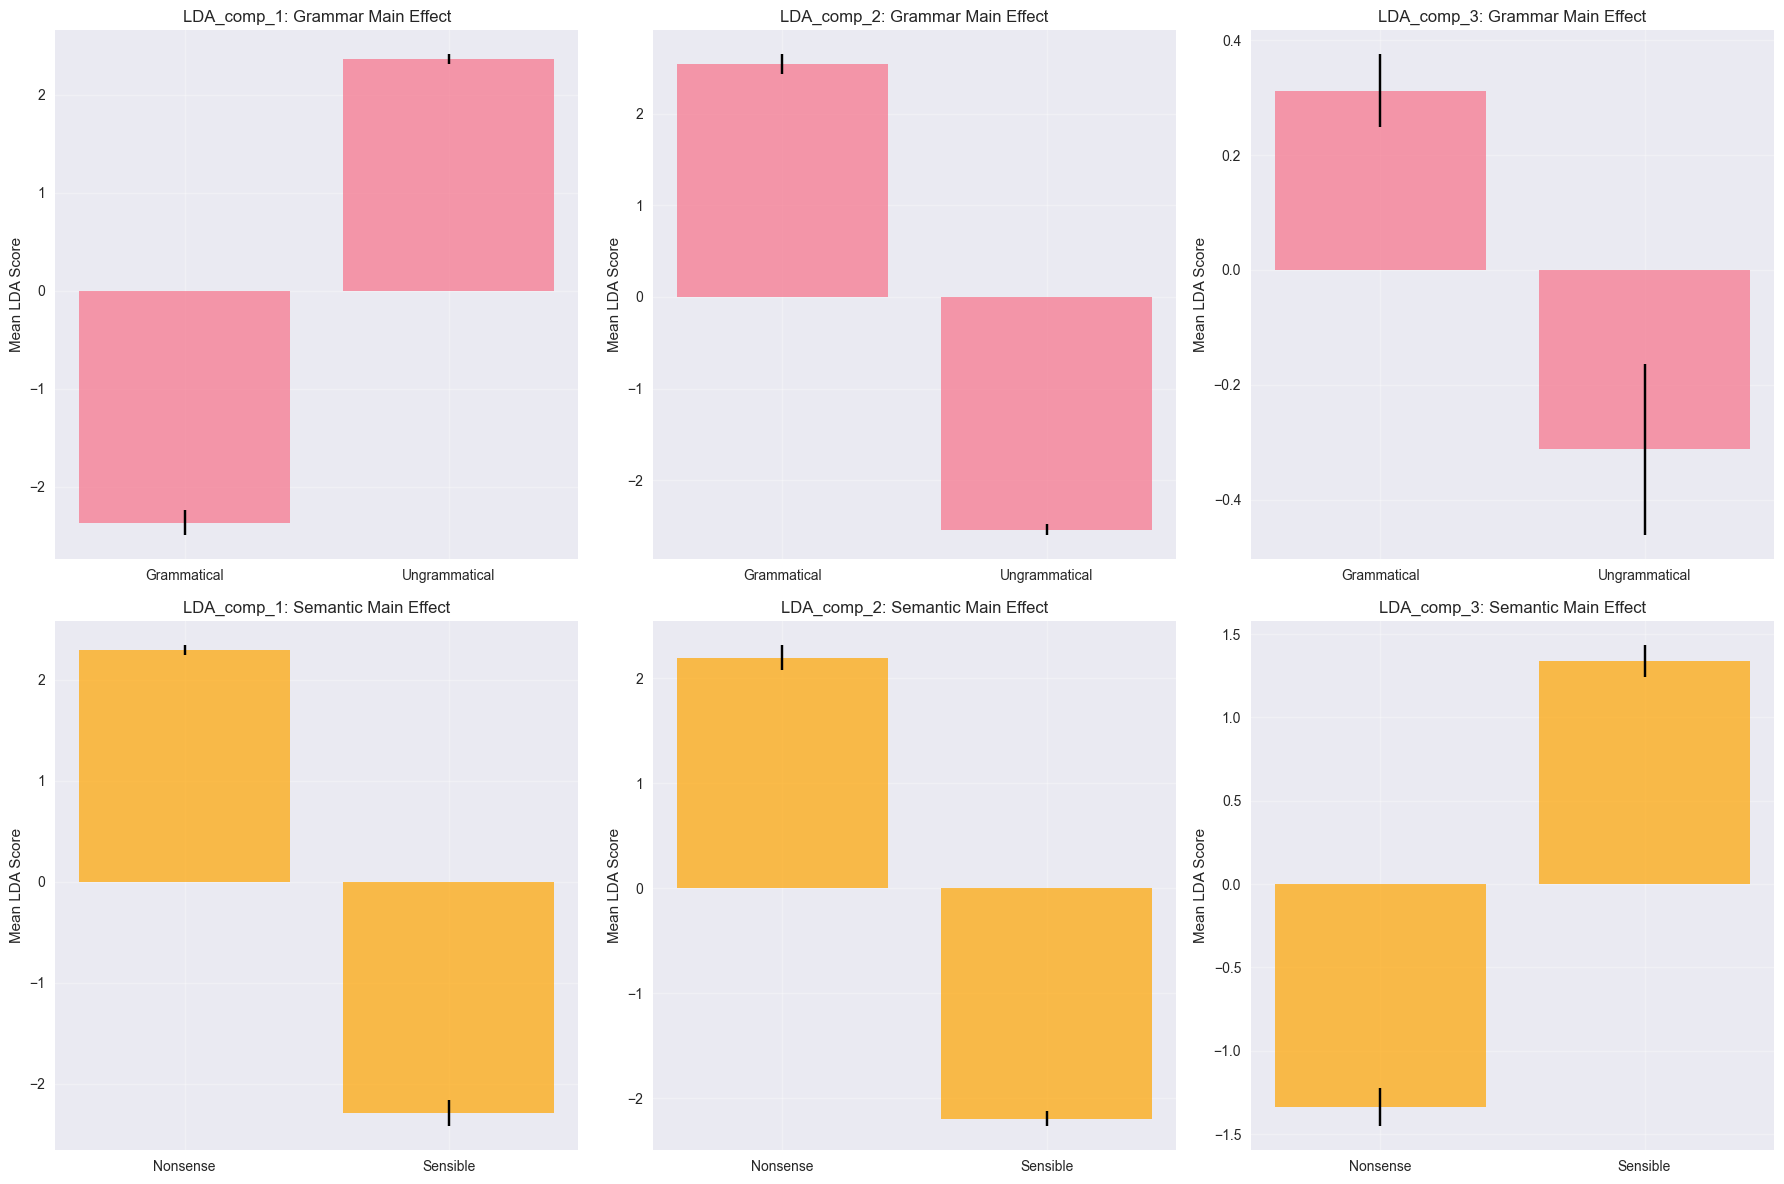

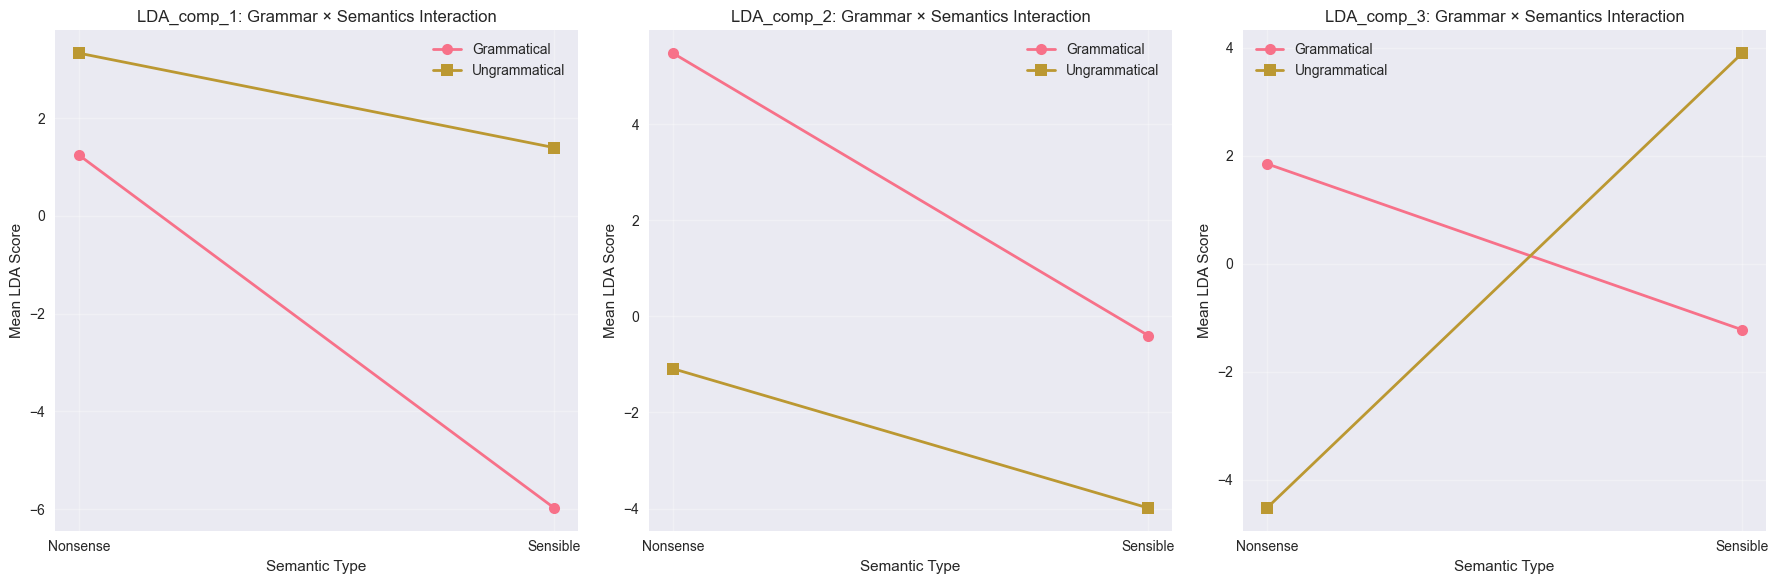


🔄 STEP 9: GENERATING FINAL REPORT
Synthesizing all results into a comprehensive conclusion...

🎯 FINAL REPORT: LDA LINEAR ANALYSIS OF EEG DATA
Research Question: Does the brain care about grammar for grammar's sake, or because grammar enhances sensibility?

📋 1. STUDY OVERVIEW AND DATA QUALITY:
   📊 Sample Size: 1680 trials total
   👥 Participants: 14 individuals
   🧪 Experimental Conditions: GN, GS, UN, US
   📈 LDA Components Analyzed: 3 (capturing maximum discriminant information)
   ✅ Balanced Design: 420 trials per condition

📊 2. DETAILED STATISTICAL RESULTS:

   🔍 LDA_COMP_1 RESULTS:
      ✅ GRAMMAR: Significant effect (p = 0.0000)
         Effect size: large (Cohen's d = -1.673)
         → Brain distinguishes grammatical from ungrammatical sentences
      ✅ SEMANTICS: Significant effect (p = 0.0000)
         Effect size: large (Cohen's d = -1.584)
         → Brain distinguishes sensible from nonsense sentences
      🔄 INTERACTION: Strong (-5.288)
         → Grammar effects are 